<a href="https://colab.research.google.com/github/aletbm/Prediccion_del_clima_CoderHouse/blob/main/1er_Entrega_Proyecto_Final_Rios_Alexander_Daniel_CoderHouse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediccion del clima

<img src="https://wallpapercave.com/wp/wp9772066.jpg">

## Objetivo
Imagina que sales de tu casa listo para disfrutar de un excelente y soleado dia, incluso planeas tener una cita en el parque con alguien, y disfrutar de un helado.
Pero inesperadamente el clima comienza a tornarse ventoso, las primeras nubes comienzan a asomarse lentamente, ves destellos de luz pensando que alguien se saco una foto y saliste en ella despeinado, pero te percatas de que esta por iniciarse una tormenta electrica e incluso al mirar al cielo sientes pequeñas gotas de agua caer sobre ti, si mi amigo, una desafortunada lluvia esta por asomarse amenazando con arruinar todos tus planes, y agarrandote la cabeza recuerdas que hubiera sido buena idea haber visto el pronostico antes de salir de casa, ya que tampoco llevas tu paraguas contigo "¡Que mala suerte 😢!" piensas.

Lo bueno es que tengo buenas noticias para ti, esos dias se podrian acabar! En este notebook desarrollare para ti una herramienta que podria ayudarte a planificar mejor tus actividades, o bueno al menos sabras cuando llevar el paraguas de paseo no? 🤭.

¿Como podemos hacer esto posible?. Bueno siendo sinceros, esto ya se hace desde tiempos inmemorables, de multiples formas el ser humano se ha arreglado para predecir el tiempo, algunos metodos han resultado mas efectivos que otros y no somos quienes para criticar los resultados ya que predecir el clima no es una tarea facil, se deben tener en cuenta cientos de parametros y muchas veces esta tarea, para un solo ser humano, puede ser compleja, por eso es que pondremos a merced de nuestros deseos algunos algoritmos de aprendizaje automatico.

Pero antes, debemos conseguir una fuente fiable de datos y posteriormente analizarla y limpiarla, pero supongamos por un momento que esto ya lo tenemos nos surgen algunas preguntas claves:

>¿Existira algun patron que nos permita identificar un dia posiblemente lluvioso?

>¿Que parametros son vitales para predecir un dia lluvioso? Y de ser asi, ¿Como se relacionan?

>¿Habra una epoca del año en la que haya mayores probabilidades de llover?

## Contexto comercial
El **Servicio Meteorologico Nacional de Argentina (SMNA)** ha recolectado miles de datos meteorologicos a lo largo de 10 años hasta la fecha actual. Nos han contratado para desarrollar y mantener una herramienta que sea capaz de predecir, en tiempo real, el pronostico nacional, con el fin de poner a disposicion de la poblacion el pronostico esperado, y mantenerlos en estado de alerta cuando sea necesario, evitando asi perdidas inesperadas a causa de haber brindado un servicio mas preciso.

## Problema comercial
En base a los datos presentados por el SMNA, se requiere realizar visualizaciones que permitan responder las siguiente preguntas:
>¿Cuales son las probabilidades de precipitaciones?

>¿A que hora es probable que comiencen las precipitaciones?

>¿Habran mas dias de precipitaciones esta semana?

>¿Como afecta la temperatura a las probabilidades de precipitaciones?

>¿Como afecta la presion superficial a las probabilidades de precipitaciones?

## Contexto analítico
El SMNA nos ha proporcionado una API de datos que es capaz de brindarnos los datos meteorologicos recolectados, algunas de las caracteristicas confeccionadas son, por ejemplo, temperaturas a diferentes alturas de la superficie, presion superficial, velocidad del viento sensadas a diferentes alturas de la superficie, entre otras 61 caracteristicas disponibles.
Al ser un un set de datos cronologicamente confeccionado puede considerarse a la fecha de confeccion como el indice interno.
De acuerdo a estos datos, debemos realizar las siguiente tareas:
>Leer y hacer una vista previa del set de datos.

>Detectar y procesar datos faltantes, determinar si pueden ser descartados y en caso contrario rellenarlos.

>Detectar outliers y procesarlos.

>Determinar caracteristicas relevantes.

>Analizar y realizar visualizaciones sobre los datos que nos permita responder aquellas preguntas realizadas y que nos permitan identificar patrones utiles.

## Humano precavido vale por 3 asi que *¡Manos a la obra!* 😊

---

In [528]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [529]:
!pip install mplcyberpunk missingno calplot

In [530]:
import json
from datetime import datetime, timedelta
import urllib.request
import pandas as pd
import numpy as np
from pandas import json_normalize
from pprint import pprint as pp

from xgboost import XGBRegressor, DMatrix, train as xgbtrain
from scipy.signal import find_peaks
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt
import seaborn as sns
import mplcyberpunk
import missingno as msno

from IPython.display import Javascript
def adjust_display():
  display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 50000})'''))

plt.style.use("cyberpunk")
pd.options.display.max_columns = None

# ¿Donde podemos obtener datos meteorologicos?

<img src="https://pbs.twimg.com/profile_images/1591121427893190664/LtkaUCDu_400x400.jpg">

[Open-Meteo](https://open-meteo.com) es una API meteorológica de código abierto y ofrece acceso gratuito para uso no comercial. La cual no exije uso de API key.

Open-Meteo se asocia con servicios meteorológicos nacionales para brindarle datos abiertos con alta resolución, que van de 1 a 11 kilómetros.

Las API de Open-Meteo están diseñadas para brindarle la información meteorológica más precisa para su ubicación.

## ¿Y como podemos obtener acceso a estos datos?

<img src="https://drive.google.com/uc?export=view&id=1LRIgscx5-WIdozjMn41k-dnIRxbFnUER">

Mediante su [Historical Weather API](https://open-meteo.com/en/docs/historical-weather-api), obtenemos acceso a más de 80 años de datos meteorológicos por hora, que cubren cualquier lugar del planeta, todo con una resolución de 10 kilómetros. Este extenso conjunto de datos nos permite profundizar en el pasado y analizar patrones climáticos históricos.

Allí dentro podemos ajustar algunas opciones sobre los datos que queremos obtener:

<img src="https://drive.google.com/uc?export=view&id=1MmVTDVFHnguINAsgVWfHOtGgOHg8x2MX">

A priori decidi traer toda la informacion historica disponible, luego me encargare de limpiarla y conservar la que considere realmente util.

Una vez que realizamos la configuracion de los datos que queremos traer, se nos habilitara la API url desde la cual podemos obtener los datos con Python, como veremos mas adelante:

<img src="https://drive.google.com/uc?export=view&id=1tGP_uhIs8DqU2pWCFSbjOuUFo-zoac0Z">

A su vez, la plataforma nos brinda una vista previa interactiva de los datos solicitados:

<img src="https://drive.google.com/uc?export=view&id=1dzmhW6rvseCGh-flqYSdiSHrByzGf6kE">

Podemos consultar la documentacion de la API desde [aqui](https://open-meteo.com/en/docs/historical-weather-api#api-documentation).

## Definición de parámetros horarios
<table>
<tr><th>Variable</th><th>Valid time</th><th>Unit</th><th>Description</th></tr>
<tr><td>temperature_2m</td><td>Instant</td><td>°C (°F)</td><td>Air temperature at 2 meters above ground</td></tr>
<tr><td>relativehumidity_2m</td><td>Instant</td><td>%</td><td>Relative humidity at 2 meters above ground</td></tr>
<tr><td>dewpoint_2m</td><td>Instant</td><td>°C (°F)</td><td>Dew point temperature at 2 meters above ground</td></tr>
<tr><td>apparent_temperature</td><td>Instant</td><td>°C (°F)</td><td>Apparent temperature is the perceived feels-like temperature combining wind chill factor, relative humidity and solar radiation</td></tr>
<tr><td>pressure_msl<br>
surface_pressure</td><td>Instant</td><td>hPa</td><td>Atmospheric air pressure reduced to mean sea level (msl) or pressure at surface. Typically pressure on mean sea level is used in meteorology. Surface pressure gets lower with increasing elevation.</td></tr>
<tr><td>precipitation</td><td>Preceding hour sum</td><td>mm (inch)</td><td>Total precipitation (rain, showers, snow) sum of the preceding hour. Data is stored with a 0.1 mm precision. If precipitation data is summed up to monthly sums, there might be small inconsistencies with the total precipitation amount.</td></tr>
<tr><td>rain</td><td>Preceding hour sum</td><td>mm (inch)</td><td>Only liquid precipitation of the preceding hour including local showers and rain from large scale systems.</td></tr>
<tr><td>snowfall</td><td>Preceding hour sum</td><td>cm (inch)</td><td>Snowfall amount of the preceding hour in centimeters. For the water equivalent in millimeter, divide by 7. E.g. 7 cm snow = 10 mm precipitation water equivalent</td></tr>
<tr><td>cloudcover</td><td>Instant</td><td>%</td><td>Total cloud cover as an area fraction</td></tr>
<tr><td>cloudcover_low</td><td>Instant</td><td>%</td><td>Low level clouds and fog up to 2 km altitude</td></tr>
<tr><td>cloudcover_mid</td><td>Instant</td><td>%</td><td>Mid level clouds from 2 to 6 km altitude</td></tr>
<tr><td>cloudcover_high</td><td>Instant</td><td>%</td><td>High level clouds from 6 km altitude</td></tr>
<tr><td>shortwave_radiation</td><td>Preceding hour mean</td><td>W/m²</td><td>Shortwave solar radiation as average of the preceding hour. This is equal to the total global horizontal irradiation</td></tr>
<tr><td>direct_radiation<br>
direct_normal_irradiance</td><td>Preceding hour mean</td><td>W/m²</td><td>Direct solar radiation as average of the preceding hour on the horizontal plane and the normal plane (perpendicular to the sun)</td></tr>
<tr><td>diffuse_radiation</td><td>Preceding hour mean</td><td>W/m²</td><td>Diffuse solar radiation as average of the preceding hour</td></tr>
<tr><td>windspeed_10m<br>
windspeed_100m</td><td>Instant</td><td>km/h (mph, m/s, knots)</td><td>Wind speed at 10 or 100 meters above ground. Wind speed on 10 meters is the standard level.</td></tr>
<tr><td>winddirection_10m<br>
winddirection_100m</td><td>Instant</td><td>°</td><td>Wind direction at 10 or 100 meters above ground</td></tr>
<tr><td>windgusts_10m</td><td>Preceding hour max</td><td>km/h (mph, m/s, knots)</td><td>Gusts at 10 meters above ground of the indicated hour. Wind gusts in CERRA are defined as the maximum wind gusts of the preceding hour. Please consult the ECMWF IFS documentation for more information on how wind gusts are parameterized in weather models.</td></tr>
<tr><td>et0_fao_evapotranspiration</td><td>Preceding hour sum</td><td>mm (inch)</td><td>ET₀ Reference Evapotranspiration of a well watered grass field. Based on FAO-56 Penman-Monteith equations ET₀ is calculated from temperature, wind speed, humidity and solar radiation. Unlimited soil water is assumed. ET₀ is commonly used to estimate the required irrigation for plants.</td></tr>
<tr><td>weathercode</td><td>Instant</td><td>WMO code</td><td>Weather condition as a numeric code. Follow WMO weather interpretation codes. See table below for details.</td></tr>
<tr><td>snow_depth</td><td>Instant</td><td>meters</td><td>Snow depth on the ground. Snow depth in ERA5-Land tends to be overestimated. As the spatial resolution for snow depth is limited, please use it with care.</td></tr>
<tr><td>vapor_pressure_deficit</td><td>Instant</td><td>kPa</td><td>Vapor Pressure Deficit (VPD) in kilopascal (kPa). For high VPD (>1.6), water transpiration of plants increases. For low VPD (<0.4), transpiration decreases</td></tr>
<tr><td>soil_temperature_0_to_7cm<br>
soil_temperature_7_to_28cm<br>
soil_temperature_28_to_100cm<br>
soil_temperature_100_to_255cm</td><td>Instant</td><td>°C (°F)</td><td>Average temperature of different soil levels below ground.</td></tr>
<tr><td>soil_moisture_0_to_7cm<br>
soil_moisture_7_to_28cm<br>
soil_moisture_28_to_100cm<br>
soil_moisture_100_to_255cm</td><td>Instant</td><td>m³/m³</td><td>Average soil water content as volumetric mixing ratio at 0-7, 7-28, 28-100 and 100-255 cm depths.</td></tr>
</table>

## Definición de parámetros diarios
<table>
<tr><th>Variable</th><th>Unit</th><th>Description</th></tr>
<tr><td>weathercode</td><td>WMO code</td><td>The most severe weather condition on a given day</td></tr>
<tr><td>temperature_2m_max<br>
temperature_2m_min</td><td>°C (°F)</td><td>Maximum and minimum daily air temperature at 2 meters above ground</td></tr>
<tr><td>apparent_temperature_max<br>
apparent_temperature_min</td><td>°C (°F)</td><td>Maximum and minimum daily apparent temperature</td></tr>
<tr><td>precipitation_sum</td><td>mm</td><td>Sum of daily precipitation (including rain, showers and snowfall)</td></tr>
<tr><td>rain_sum</td><td>mm</td><td>Sum of daily rain</td></tr>
<tr><td>snowfall_sum</td><td>cm</td><td>Sum of daily snowfall</td></tr>
<tr><td>precipitation_hours</td><td>hours</td><td>The number of hours with rain</td></tr>
<tr><td>sunrise<br>
sunset</td><td>iso8601</td><td>Sun rise and set times</td></tr>
<tr><td>windspeed_10m_max<br>
windgusts_10m_max</td><td>km/h (mph, m/s, knots)</td><td>Maximum wind speed and gusts on a day</td></tr>
<tr><td>winddirection_10m_dominant</td><td>°</td><td>Dominant wind direction</td></tr>
<tr><td>shortwave_radiation_sum</td><td>MJ/m²</td><td>The sum of solar radiation on a given day in Megajoules</td></tr>
<tr><td>et0_fao_evapotranspiration</td><td>mm</td><td>Daily sum of ET₀ Reference Evapotranspiration of a well watered grass field</td></tr>
</table>

# Obtencion de datos

In [531]:
#Datos de Argentina
latitud = "-34"
longitud = "-64"

start_date = "2000-01-01"
end_date = str((datetime.today() - timedelta(days=1)).date())

actualizar_datos = False

weather_url = f"""
          https://archive-api.open-meteo.com/v1/archive?
          latitude={latitud}
          &longitude={longitud}
          &start_date={start_date}
          &end_date={end_date}
          &hourly=temperature_2m,
            relativehumidity_2m,
            dewpoint_2m,
            apparent_temperature,
            precipitation,
            rain,snowfall,
            weathercode,
            pressure_msl,
            surface_pressure,
            cloudcover,
            cloudcover_low,
            cloudcover_mid,
            cloudcover_high,
            et0_fao_evapotranspiration,
            vapor_pressure_deficit,
            windspeed_10m,
            windspeed_100m,
            winddirection_10m,
            winddirection_100m,
            windgusts_10m,
            soil_temperature_0_to_7cm,
            soil_temperature_7_to_28cm,
            soil_temperature_28_to_100cm,
            soil_temperature_100_to_255cm,
            soil_moisture_0_to_7cm,
            soil_moisture_7_to_28cm,
            soil_moisture_28_to_100cm,
            soil_moisture_100_to_255cm,
            is_day,
            shortwave_radiation,
            direct_radiation,
            diffuse_radiation,
            direct_normal_irradiance,
            terrestrial_radiation,
            shortwave_radiation_instant,
            direct_radiation_instant,
            diffuse_radiation_instant,
            direct_normal_irradiance_instant,
            terrestrial_radiation_instant
          &daily=weathercode,
            temperature_2m_max,
            temperature_2m_min,
            temperature_2m_mean,
            apparent_temperature_max,
            apparent_temperature_min,
            apparent_temperature_mean,
            sunrise,sunset,
            precipitation_sum,
            rain_sum,snowfall_sum,
            precipitation_hours,
            windspeed_10m_max,
            windgusts_10m_max,
            winddirection_10m_dominant,
            shortwave_radiation_sum,
            et0_fao_evapotranspiration
          &timezone=America%2FSao_Paulo
          """
weather_url = weather_url.replace("\n", "").replace(" ", "")

if actualizar_datos == True:
  with urllib.request.urlopen(weather_url) as weather:
    weather=json.loads(weather.read().decode())
    df_weather = pd.DataFrame(weather["daily"])
    df_aux = pd.DataFrame(weather["hourly"])
else:
  df_weather = pd.read_csv("/content/drive/MyDrive/Coder/Data Science/Desafio APIS/weather.csv")
  df_aux = pd.read_csv("/content/drive/MyDrive/Coder/Data Science/Desafio APIS/weather_hourly.csv")

df_weather.head()

time  weathercode  temperature_2m_max  temperature_2m_min  \
0  2000-01-01          1.0                30.5                20.9   
1  2000-01-02          2.0                31.2                20.8   
2  2000-01-03          2.0                30.2                19.5   
3  2000-01-04         51.0                28.2                20.0   
4  2000-01-05          1.0                31.0                18.5   

   temperature_2m_mean  apparent_temperature_max  apparent_temperature_min  \
0                 25.8                      32.0                      21.2   
1                 25.9                      32.5                      21.0   
2                 24.8                      31.9                      18.8   
3                 23.9                      32.9                      22.1   
4                 25.4                      35.2                      20.4   

   apparent_temperature_mean           sunrise            sunset  \
0                       26.5  2000-01-01T06:08  2000-01-01T20:30   
1                       25.9  2000-01-02T06:08  2000-01-02T20:30   
2                       25.2  2000-01-03T06:09  2000-01-03T20:30   
3                       26.3  2000-01-04T06:10  2000-01-04T20:30   
4                       28.1  2000-01-05T06:11  2000-01-05T20:31   

   precipitation_sum  rain_sum  snowfall_sum  precipitation_hours  \
0                0.0       0.0           0.0                  0.0   
1                0.0       0.0           0.0                  0.0   
2                0.0       0.0           0.0                  0.0   
3                0.9       0.9           0.0                  5.0   
4                0.0       0.0           0.0                  0.0   

   windspeed_10m_max  windgusts_10m_max  winddirection_10m_dominant  \
0               16.9               39.2                        20.0   
1               15.2               34.9                        43.0   
2               12.0               31.3                        49.0   
3               10.2               27.4                       310.0   
4                8.6               24.1                       157.0   

   shortwave_radiation_sum  et0_fao_evapotranspiration  
0                    27.40                        6.58  
1                    30.41                        7.47  
2                    30.39                        6.83  
3                    24.66                        5.02  
4                    29.86                        6.22

In [532]:
df_weather.shape, df_aux.shape

((8713, 19), (209112, 42))

In [533]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8713 entries, 0 to 8712
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   time                        8713 non-null   object 
 1   weathercode                 8712 non-null   float64
 2   temperature_2m_max          8712 non-null   float64
 3   temperature_2m_min          8712 non-null   float64
 4   temperature_2m_mean         8711 non-null   float64
 5   apparent_temperature_max    8712 non-null   float64
 6   apparent_temperature_min    8712 non-null   float64
 7   apparent_temperature_mean   8711 non-null   float64
 8   sunrise                     8713 non-null   object 
 9   sunset                      8713 non-null   object 
 10  precipitation_sum           8711 non-null   float64
 11  rain_sum                    8711 non-null   float64
 12  snowfall_sum                8711 non-null   float64
 13  precipitation_hours         8713 

In [534]:
df_aux.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209112 entries, 0 to 209111
Data columns (total 42 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Unnamed: 0                        209112 non-null  int64  
 1   time                              209112 non-null  object 
 2   temperature_2m                    209085 non-null  float64
 3   relativehumidity_2m               209085 non-null  float64
 4   dewpoint_2m                       209085 non-null  float64
 5   apparent_temperature              209085 non-null  float64
 6   precipitation                     209085 non-null  float64
 7   rain                              209085 non-null  float64
 8   snowfall                          209085 non-null  float64
 9   weathercode                       209085 non-null  float64
 10  pressure_msl                      209085 non-null  float64
 11  surface_pressure                  209085 non-null  f

In [535]:
df_weather.describe()

weathercode  temperature_2m_max  temperature_2m_min  \
count  8712.000000         8712.000000         8712.000000   
mean     19.585285           23.165496           13.248623   
std      26.102851            6.604411            5.921102   
min       0.000000            2.400000           -9.600000   
25%       1.000000           18.000000            8.500000   
50%       2.000000           23.300000           13.500000   
75%      51.000000           28.300000           18.100000   
max      73.000000           41.400000           28.500000   

       temperature_2m_mean  apparent_temperature_max  \
count          8711.000000               8712.000000   
mean             17.905258                 22.754890   
std               6.110802                  8.566685   
min              -1.900000                 -0.800000   
25%              12.900000                 15.900000   
50%              18.100000                 22.850000   
75%              22.800000                 29.500000   
max              34.400000                 43.600000   

       apparent_temperature_min  apparent_temperature_mean  precipitation_sum  \
count               8712.000000                8711.000000        8711.000000   
mean                  11.804591                  16.859936           2.017288   
std                    7.455709                   7.735340           6.223068   
min                  -14.500000                  -6.200000          -4.700000   
25%                    5.800000                  10.500000           0.000000   
50%                   11.700000                  16.800000           0.000000   
75%                   17.800000                  23.200000           0.500000   
max                   30.700000                  34.700000          90.500000   

         rain_sum  snowfall_sum  precipitation_hours  windspeed_10m_max  \
count  8711.00000   8711.000000          8713.000000        8712.000000   
mean      2.01761      0.000932             2.038334          16.819376   
std       6.22303      0.055211             4.109431           4.889495   
min       0.00000      0.000000             0.000000           5.200000   
25%       0.00000      0.000000             0.000000          13.200000   
50%       0.00000      0.000000             0.000000          16.400000   
75%       0.50000      0.000000             2.000000          19.800000   
max      90.50000      3.920000            24.000000          42.900000   

       windgusts_10m_max  winddirection_10m_dominant  shortwave_radiation_sum  \
count        8712.000000                 8711.000000              8711.000000   
mean           35.536180                  103.822638                17.851174   
std            10.316556                   87.681924                 8.222598   
min            12.600000                    0.000000                 0.860000   
25%            28.100000                   33.000000                11.490000   
50%            34.900000                   65.000000                16.960000   
75%            42.100000                  167.000000                24.670000   
max            90.400000                  360.000000                34.610000   

       et0_fao_evapotranspiration  
count                 8711.000000  
mean                     3.909441  
std                      2.112624  
min                      0.200000  
25%                      2.120000  
50%                      3.580000  
75%                      5.560000  
max                     11.640000

In [536]:
df_aux.describe()

Unnamed: 0  temperature_2m  relativehumidity_2m    dewpoint_2m  \
count  209112.000000   209085.000000        209085.000000  209085.000000   
mean   104555.500000       17.893212            64.086367      10.189921   
std     60365.579083        7.075236            19.408417       6.501479   
min         0.000000       -9.600000            11.000000     -14.200000   
25%     52277.750000       12.600000            49.000000       5.500000   
50%    104555.500000       17.900000            65.000000      10.500000   
75%    156833.250000       23.000000            80.000000      15.300000   
max    209111.000000       41.400000           100.000000      26.600000   

       apparent_temperature  precipitation           rain       snowfall  \
count         209085.000000  209085.000000  209085.000000  209085.000000   
mean              16.860955       0.084045       0.084059       0.000039   
std                8.679004       0.527664       0.527089       0.003233   
min              -14.500000     -10.700000       0.000000       0.000000   
25%               10.200000       0.000000       0.000000       0.000000   
50%               16.600000       0.000000       0.000000       0.000000   
75%               23.300000       0.000000       0.000000       0.000000   
max               43.600000      26.000000      26.000000       0.420000   

         weathercode   pressure_msl  surface_pressure     cloudcover  \
count  209085.000000  209085.000000     209085.000000  209085.000000   
mean        5.209422    1014.556167        997.100743      27.925906   
std        15.003084       6.630350          6.250965      34.272486   
min         0.000000     988.300000        971.900000       0.000000   
25%         0.000000    1010.000000        992.800000       0.000000   
50%         0.000000    1014.100000        996.700000      13.000000   
75%         1.000000    1018.700000       1001.000000      44.000000   
max        73.000000    1043.300000       1024.500000     100.000000   

       cloudcover_low  cloudcover_mid  cloudcover_high  \
count   209085.000000   209085.000000    209085.000000   
mean        15.492374       15.657924        25.845857   
std         32.178004       28.255943        35.704647   
min          0.000000        0.000000         0.000000   
25%          0.000000        0.000000         0.000000   
50%          0.000000        0.000000         2.000000   
75%          6.000000       17.000000        49.000000   
max        100.000000      100.000000       100.000000   

       et0_fao_evapotranspiration  vapor_pressure_deficit  windspeed_10m  \
count               209085.000000           209085.000000  209085.000000   
mean                     0.162883                0.887126      11.450490   
std                      0.199113                0.773239       5.024244   
min                      0.000000                0.000000       0.000000   
25%                      0.020000                0.320000       7.600000   
50%                      0.070000                0.660000      10.900000   
75%                      0.250000                1.220000      14.800000   
max                      1.040000                6.700000      42.900000   

       windspeed_100m  winddirection_10m  winddirection_100m  windgusts_10m  \
count   209085.000000      209085.000000       209085.000000  209085.000000   
mean        20.085973         113.674534          111.258120      24.278727   
std          8.318901          95.477924           96.439779      10.385331   
min          0.000000           1.000000            1.000000       1.100000   
25%         14.100000          34.000000           31.000000      16.200000   
50%         20.200000          74.000000           72.000000      23.000000   
75%         26.000000         182.000000          179.000000      31.000000   
max         68.200000         360.000000          360.000000      90.400000   

       soil_temperature_0_to_7cm  soil_temperature_7_to_28cm  \
count  

## Visualizando nuestro objetivo

Text(0, 0.5, 'Precipitation')

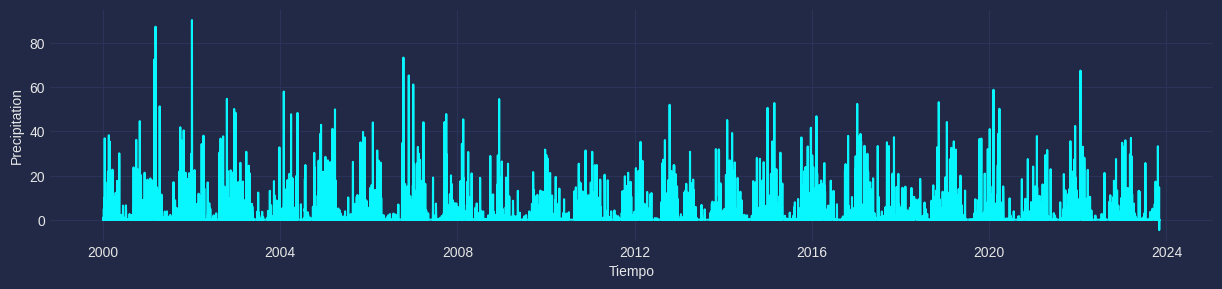

In [537]:
plt.figure(figsize=(15,3))
sns.lineplot(x=pd.to_datetime(df_weather.time), y=df_weather.precipitation_sum);
plt.xlabel("Tiempo")
plt.ylabel("Precipitation")

## Guardando datos

In [538]:
if actualizar_datos == True:
  df_weather.to_csv("/content/drive/MyDrive/Coder/Data Science/Desafio APIS/weather.csv", index=False)
  df_aux.to_csv("/content/drive/MyDrive/Coder/Data Science/Desafio APIS/weather_hourly.csv", index=False)

## Previsualizacion de algunos datos

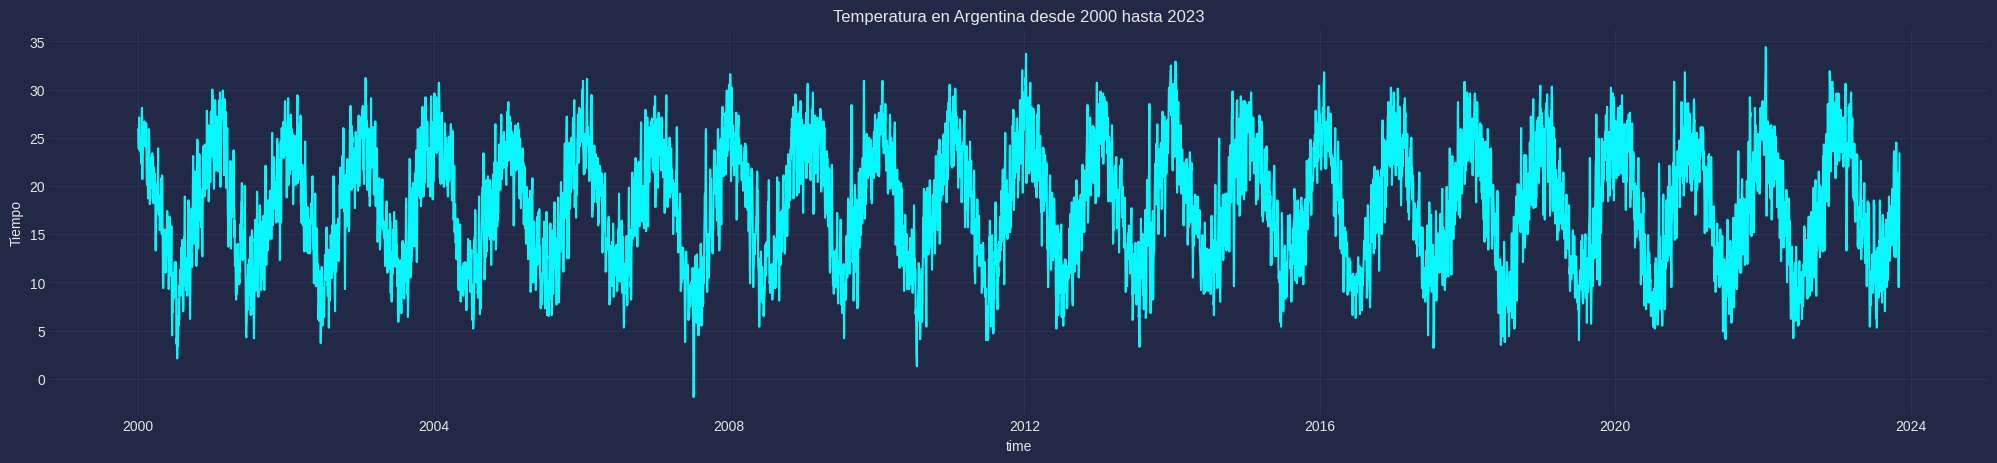

In [539]:
df_weather["time"] = pd.to_datetime(df_weather["time"])

plt.figure(figsize=(25, 5))
sns.lineplot(data=df_weather, x="time", y="temperature_2m_mean")
plt.ylabel("Temperatura")
plt.ylabel("Tiempo")
plt.title("Temperatura en Argentina desde 2000 hasta 2023");

# Data wrangling

## Tratando los datos faltantes

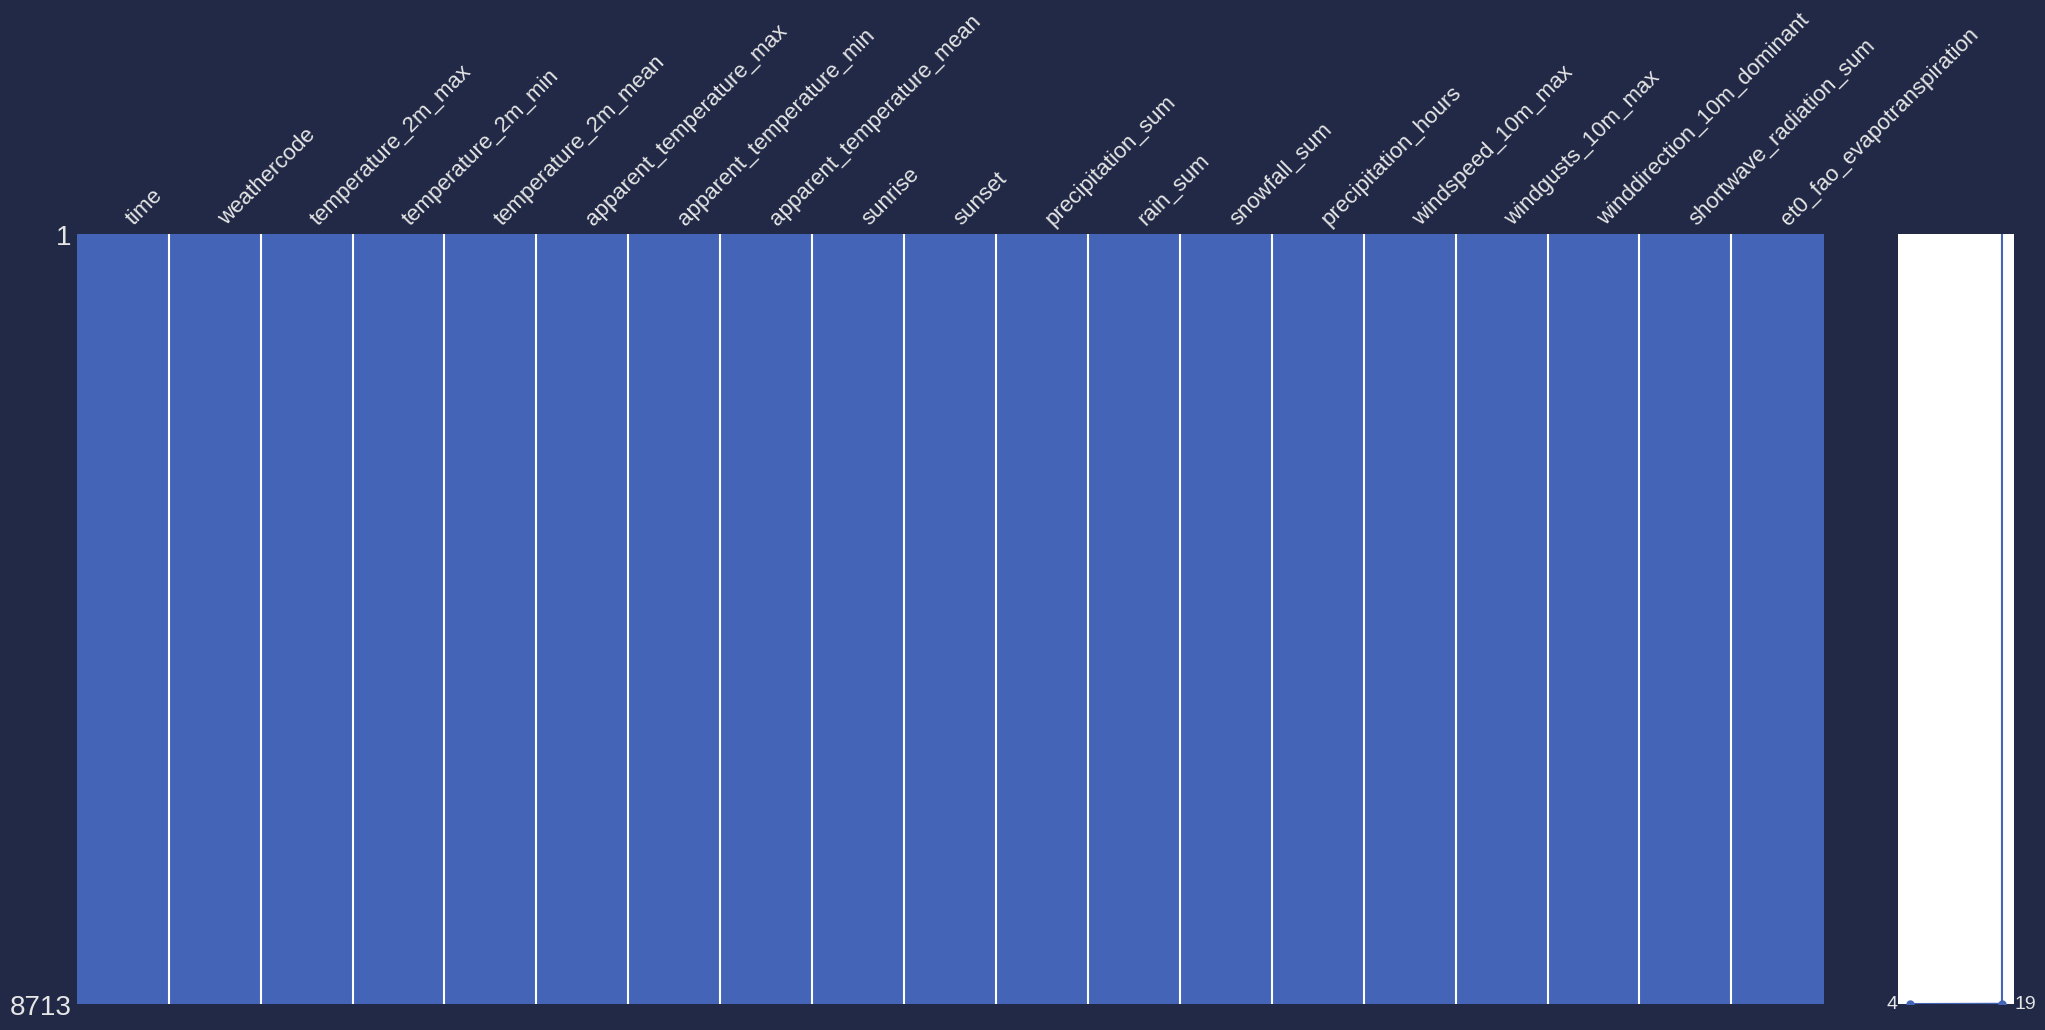

In [540]:
msno.matrix(df_weather, color=(68/255, 100/255, 184/255));

Se puede ver que hay un rango de fechas que contienen datos faltantes, veamos cual es el rango.

In [541]:
fecha_faltante_max = df_weather[df_weather.isna().any(axis=1)]["time"].max()
fecha_faltante_min = df_weather[df_weather.isna().any(axis=1)]["time"].min()

print("Faltan datos desde el", fecha_faltante_min, "hasta el", fecha_faltante_max)

print(f"Falta datos de los ultimos {str(fecha_faltante_max - fecha_faltante_min)}")

Faltan datos desde el 2023-11-07 00:00:00 hasta el 2023-11-08 00:00:00
Falta datos de los ultimos 1 days 00:00:00


Podemos observar tambien que la mayoria de columnas en este rango de fechas tienen datos faltantes, teniendo esto en cuenta lo mejor sera eliminar estos registros.

In [542]:
index_faltantes = df_weather[(df_weather["time"] >= fecha_faltante_min) & (df_weather["time"] <= fecha_faltante_max)].index
df_weather.drop(index_faltantes, axis=0, inplace=True)

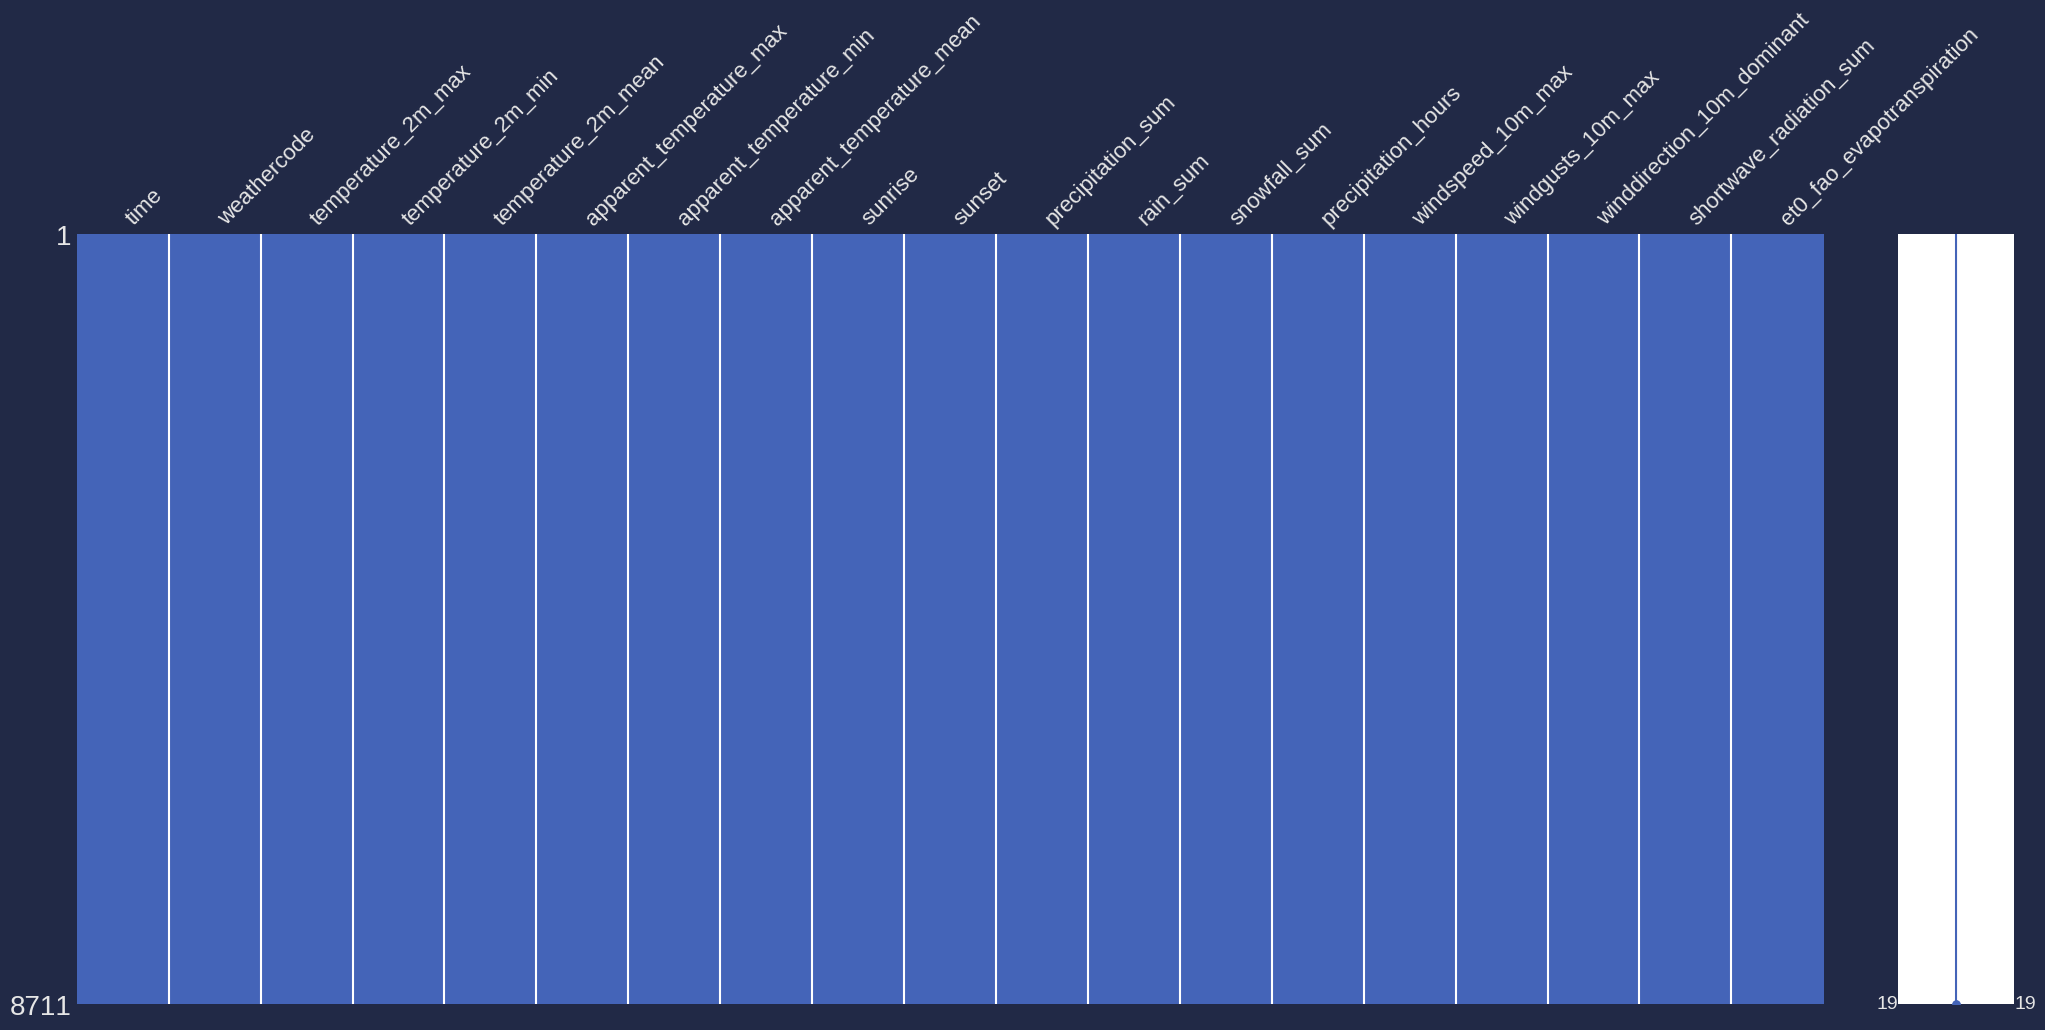

In [543]:
msno.matrix(df_weather, color=(68/255, 100/255, 184/255));

## Buscando datos duplicados

Al ser datos con una secuencia temporal seria raro encontrar datos duplicados, pero siempre es bueno verificar esto.

In [544]:
df_weather.duplicated().sum()

0

Como sospeche, no hay datos duplicados.

# Data transformation

Una peculiaridad que podemos ver en este set de datos final es que la mayoria de datos, por no decir todas, son caracteristicas numericas, exceptuando las fechas. Trabajemos un poco sobre ellas.

In [545]:
df = df_weather.copy()

df["date"] = df["time"].dt.date
df["hour"] = df["time"].dt.hour

df["date"] = pd.to_datetime(df["date"])

df["day"] = df.date.dt.day
df["month"] = df.date.dt.month
df["year"] = df.date.dt.year
df["week"] = df.date.dt.isocalendar().week.astype('int32')
df["quarter"] = df.date.dt.quarter
df["day_of_year"] = df.date.dt.day_of_year
df["day_of_week"] = df.date.dt.day_of_week

df[["date", "day", "month", "year", "week", "quarter", "day_of_year", "day_of_week"]]

date  day  month  year  week  quarter  day_of_year  day_of_week
0    2000-01-01    1      1  2000    52        1            1            5
1    2000-01-02    2      1  2000    52        1            2            6
2    2000-01-03    3      1  2000     1        1            3            0
3    2000-01-04    4      1  2000     1        1            4            1
4    2000-01-05    5      1  2000     1        1            5            2
...         ...  ...    ...   ...   ...      ...          ...          ...
8706 2023-11-02    2     11  2023    44        4          306            3
8707 2023-11-03    3     11  2023    44        4          307            4
8708 2023-11-04    4     11  2023    44        4          308            5
8709 2023-11-05    5     11  2023    44        4          309            6
8710 2023-11-06    6     11  2023    45        4          310            0

[8711 rows x 8 columns]

In [546]:
df["sunset"] = pd.to_datetime(df["sunset"])
df["sunrise"] = pd.to_datetime(df["sunrise"])

df["sunrise_hour"] = df.sunrise.dt.hour
df["sunrise_minute"] = df.sunrise.dt.minute

df["sunset_hour"] = df.sunset.dt.hour
df["sunset_minute"] = df.sunset.dt.minute

df[["sunset", "sunset_hour", "sunset_minute", "sunrise", "sunrise_hour", "sunrise_minute"]]

sunset  sunset_hour  sunset_minute             sunrise  \
0    2000-01-01 20:30:00           20             30 2000-01-01 06:08:00   
1    2000-01-02 20:30:00           20             30 2000-01-02 06:08:00   
2    2000-01-03 20:30:00           20             30 2000-01-03 06:09:00   
3    2000-01-04 20:30:00           20             30 2000-01-04 06:10:00   
4    2000-01-05 20:31:00           20             31 2000-01-05 06:11:00   
...                  ...          ...            ...                 ...   
8706 2023-11-02 19:44:00           19             44 2023-11-02 06:14:00   
8707 2023-11-03 19:45:00           19             45 2023-11-03 06:13:00   
8708 2023-11-04 19:46:00           19             46 2023-11-04 06:12:00   
8709 2023-11-05 19:47:00           19             47 2023-11-05 06:11:00   
8710 2023-11-06 19:48:00           19             48 2023-11-06 06:10:00   

      sunrise_hour  sunrise_minute  
0                6               8  
1                6               8  
2                6               9  
3                6              10  
4                6              11  
...            ...             ...  
8706             6              14  
8707             6              13  
8708             6              12  
8709             6              11  
8710             6              10  

[8711 rows x 6 columns]

In [547]:
df.drop(["sunset", "sunrise"], axis=1, inplace=True)

In [548]:
df["precipitation_sum"].autocorr(lag=11)

0.0672077552232274

# Data StoryTelling

## ☂️ Llevo el paraguas o lo dejo en casa?

Esta es una pregunta muy frecuente que nos hacemos antes de salir de casa cuando tenemos indicios de que el cielo puede precipitarse, por lo que antes que nada, definamos la variable que nos ayudara a predecir la cantidad de precipitacion que habra el dia de mañana, la cual nos servira como target para la tarea que deseamos realizar.

In [549]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8711 entries, 0 to 8710
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   time                        8711 non-null   datetime64[ns]
 1   weathercode                 8711 non-null   float64       
 2   temperature_2m_max          8711 non-null   float64       
 3   temperature_2m_min          8711 non-null   float64       
 4   temperature_2m_mean         8711 non-null   float64       
 5   apparent_temperature_max    8711 non-null   float64       
 6   apparent_temperature_min    8711 non-null   float64       
 7   apparent_temperature_mean   8711 non-null   float64       
 8   sunrise                     8711 non-null   object        
 9   sunset                      8711 non-null   object        
 10  precipitation_sum           8711 non-null   float64       
 11  rain_sum                    8711 non-null   float64     

Claramente de todas estas variables la que es de nuestro interes para la prediccion es "precipitation" la cual nos indica la suma de precipitacion de la hora anterior en milimetros.


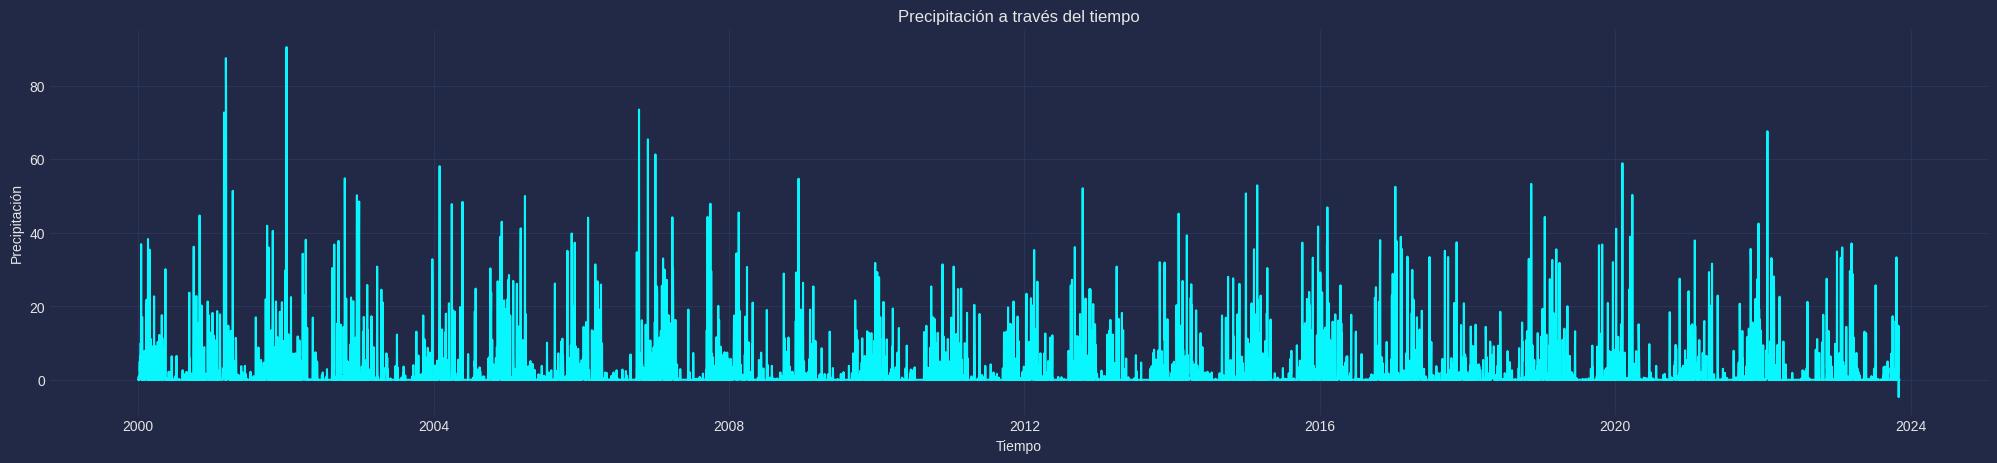

In [560]:
plt.figure(figsize=(25, 5))
sns.lineplot(data=df, y="precipitation_sum", x="time")
plt.xlabel("Tiempo")
plt.ylabel("Precipitación")
plt.title("Precipitación a través del tiempo");

Se puede observar un patron casi periodico, donde hay un lapso temporal donde las precipitaciones son minimas y donde las precipitaciones alcanzan una maximo, para verlo mas claro calcular el Exponential Moving Average de las precipitaciones en un periodo de 4 meses.

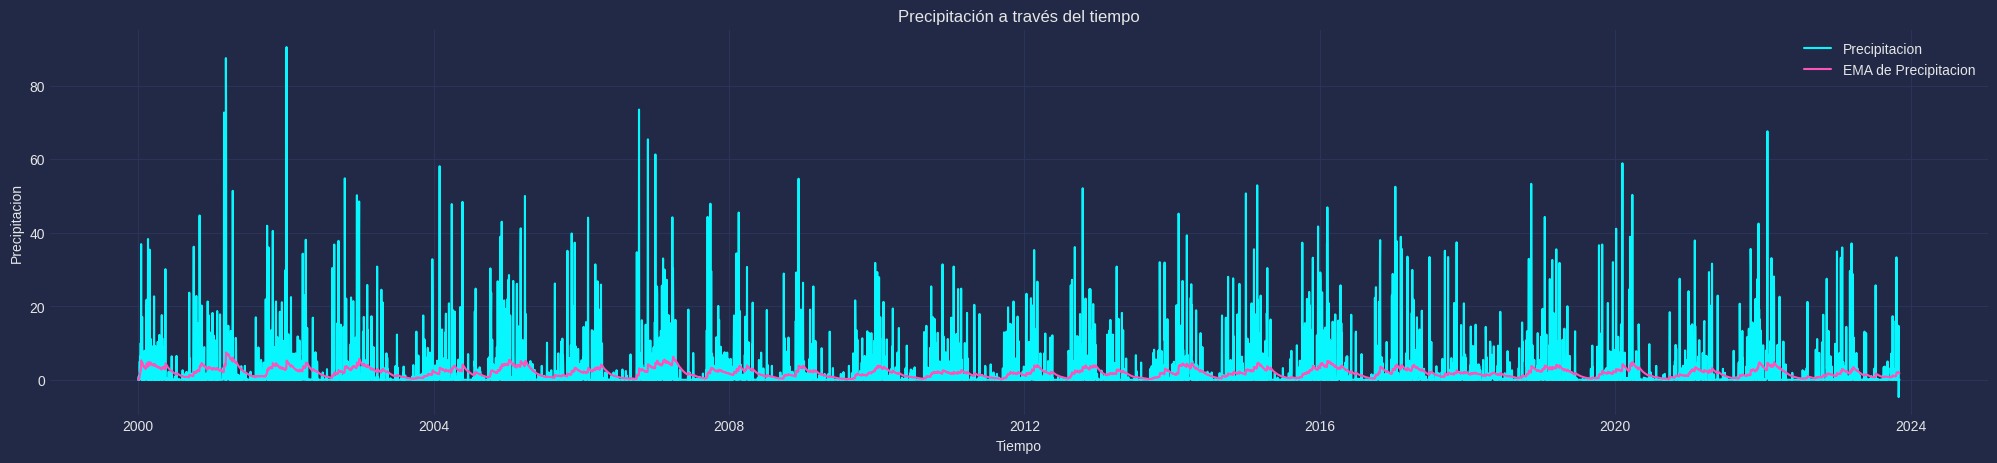

In [564]:
sma_precipitation = df["precipitation_sum"].ewm(7*6).mean() #Exponential moving average

plt.figure(figsize=(25, 5))
sns.lineplot(data=df, y="precipitation_sum", x="time", legend='brief', label="Precipitacion")
sns.lineplot(y=sma_precipitation,  x=df["time"], legend='brief', label="EMA de Precipitacion")
plt.xlabel("Tiempo")
plt.ylabel("Precipitacion")
plt.title("Precipitación a través del tiempo");

Se puede observar que un lapso de 4 años hay 4 maximos y 4 minimos, para verlo mas claramente hallemos los maximos y minimos.

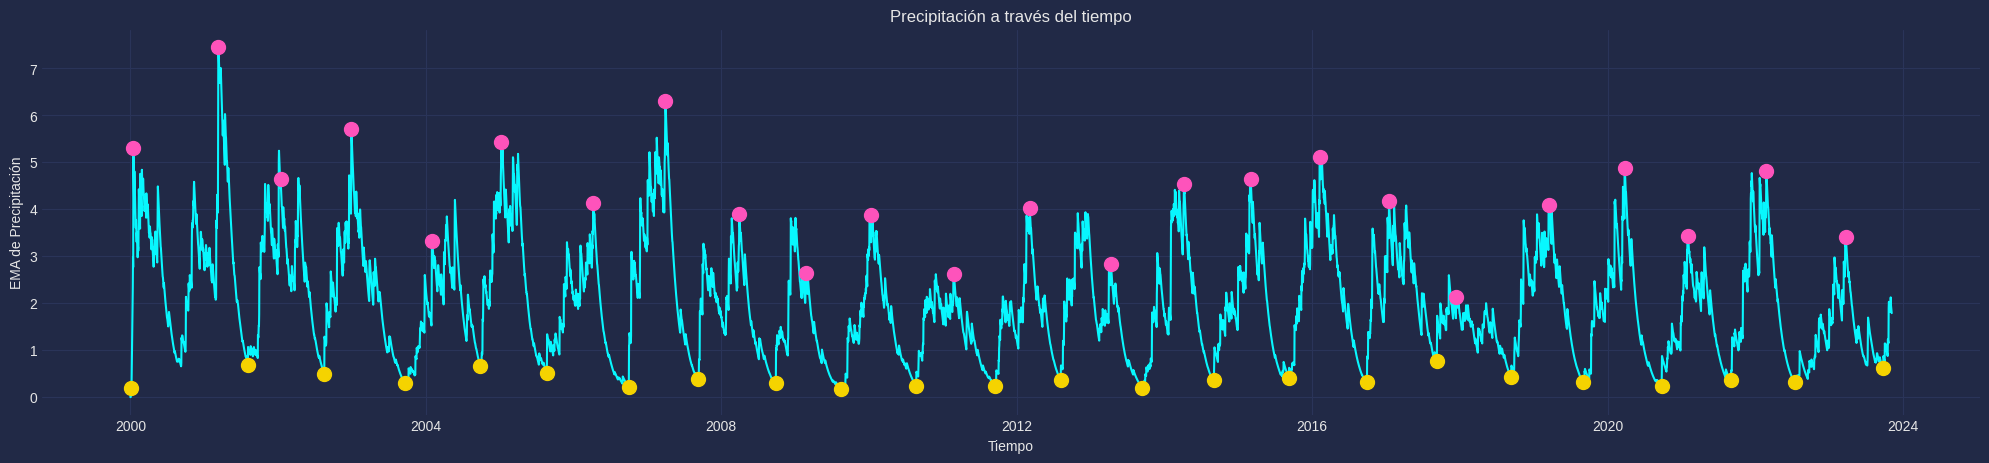

In [565]:
picos_index, _ = find_peaks(sma_precipitation, distance=7*4*11, height=2)
valles_index, _ = find_peaks(-sma_precipitation, distance=7*4*11)


plt.figure(figsize=(25, 5))
#sns.lineplot(data=df, y="precipitation", x="time")
sns.lineplot(y=sma_precipitation,  x=df["time"])
plt.plot(df.loc[picos_index, "time"], sma_precipitation[picos_index], "o", markersize=10)
plt.plot(df.loc[valles_index, "time"], sma_precipitation[valles_index], "o", markersize=10)
plt.xlabel("Tiempo")
plt.ylabel("EMA de Precipitación")
plt.title("Precipitación a través del tiempo");

## Periodo de acumulacion abundante de precipitaciones

In [470]:
df.loc[picos_index, "month"].value_counts().index.map({1:"Enero", 2:"Febrero", 3:"Marzo", 4:"Abril", 5:"Mayo", 6:"Junio", 7:"Julio", 8:"Agosto", 9:"Septiembre", 10:"Octubre", 11:"Noviembre", 12:"Diciembre"}).tolist()

['Marzo', 'Enero', 'Febrero', 'Abril', 'Diciembre']

## Periodo de acumulacion baja de precipitaciones

In [471]:
df.loc[valles_index, "month"].value_counts().index.map({1:"Enero", 2:"Febrero", 3:"Marzo", 4:"Abril", 5:"Mayo", 6:"Junio", 7:"Julio", 8:"Agosto", 9:"Septiembre", 10:"Octubre", 11:"Noviembre", 12:"Diciembre"}).tolist()

['Septiembre', 'Agosto', 'Enero', 'Julio']

A continuacion, veamos como las precipitaciones son menos abundantes hacia la mitad del año.

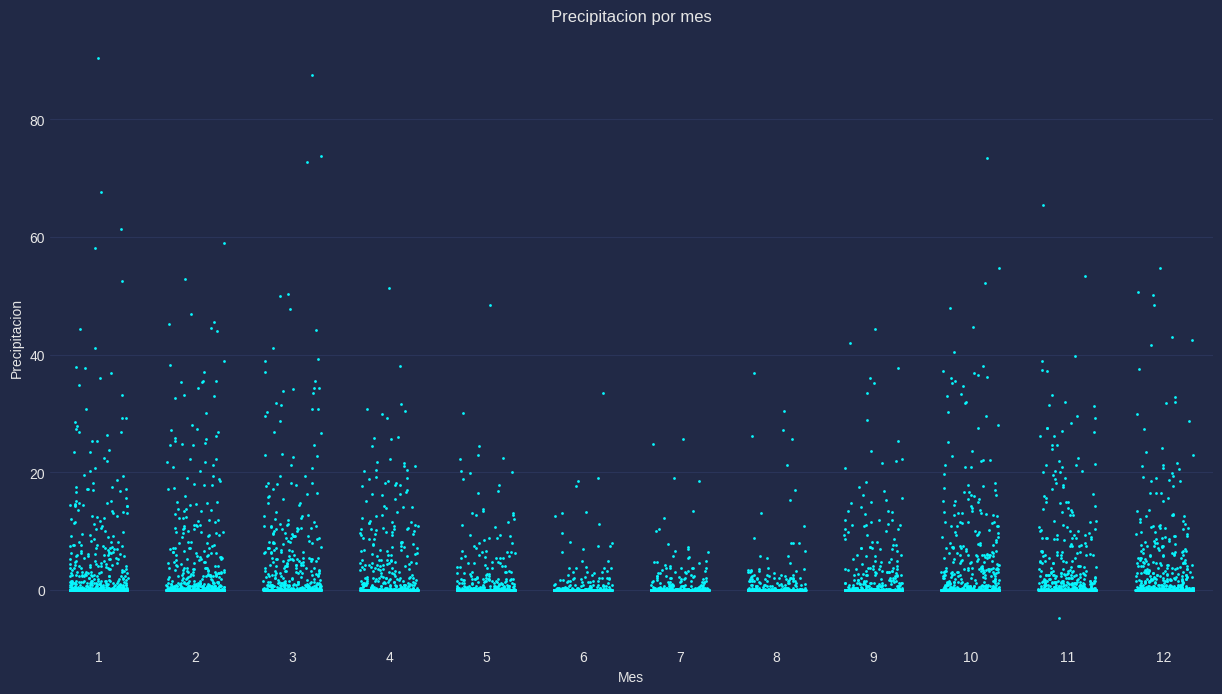

In [570]:
plt.figure(figsize=(15, 8))
sns.stripplot(data=df, y="precipitation_sum", x="month", jitter=0.3, size=2)
plt.xlabel("Mes")
plt.ylabel("Precipitacion");
plt.title("Precipitacion por mes");

## Temperatura

Algo curioso que podemos extraer del analisis anterior, es que el periodo de acumulacion de precipitaciones baja es a su vez un periodo de temperaturas bajas. Veamos si esto es asi.

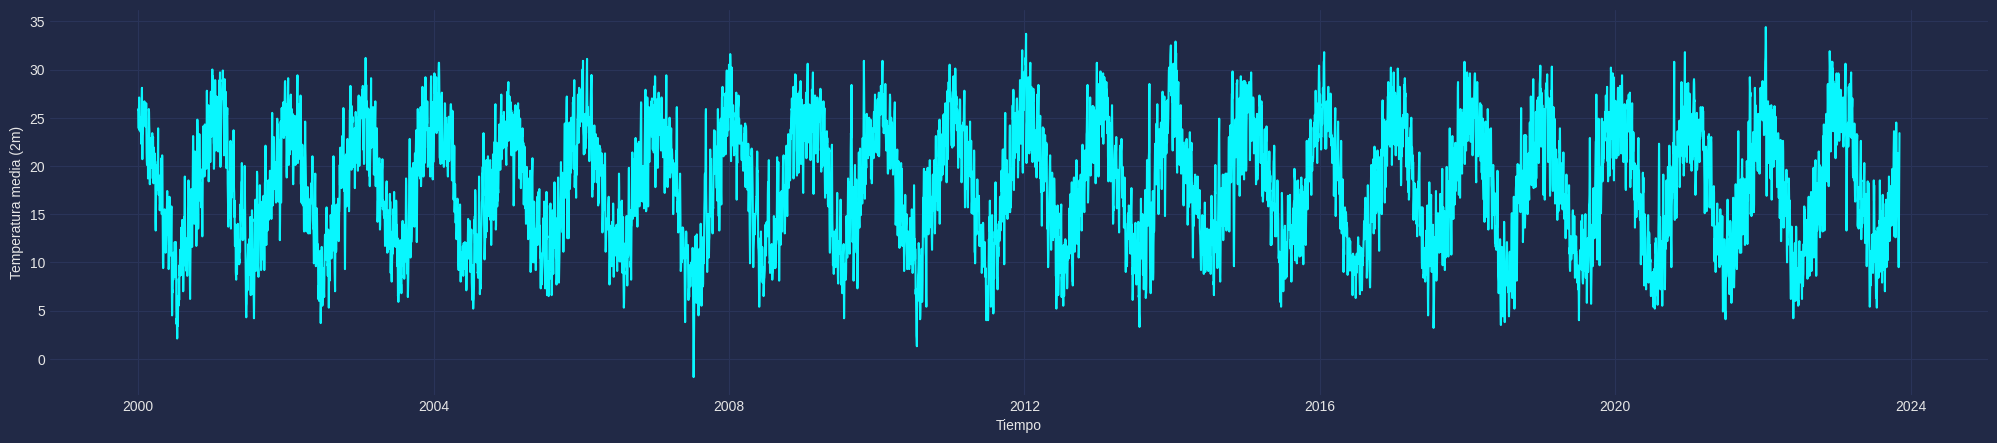

In [558]:
plt.figure(figsize=(25, 5))
sns.lineplot(data=df, y="temperature_2m_mean", x="time")
plt.xlabel("Tiempo")
plt.ylabel("Temperatura media (2m)");

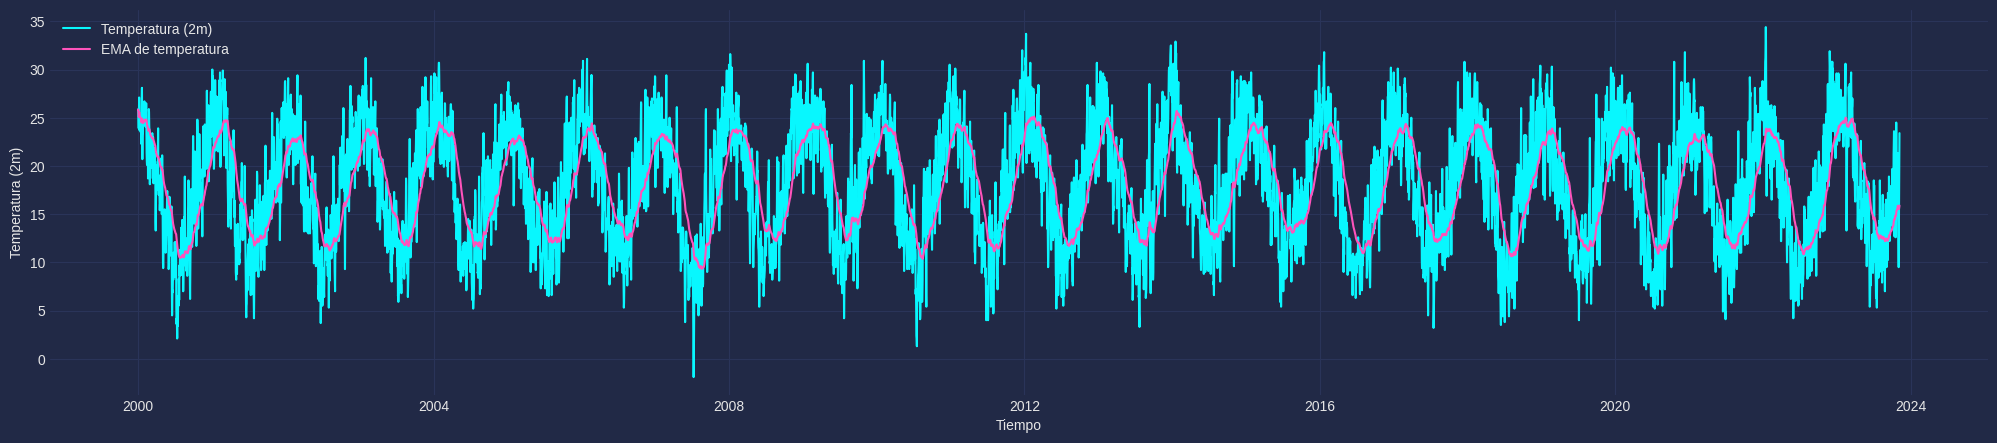

In [567]:
sma_temp = df["temperature_2m_mean"].ewm(7*6).mean()

plt.figure(figsize=(25, 5))
sns.lineplot(data=df, y="temperature_2m_mean", x="time", legend='brief', label="Temperatura (2m)")
sns.lineplot(y=sma_temp,  x=df["time"], legend='brief', label="EMA de temperatura")
plt.xlabel("Tiempo")
plt.ylabel("Temperatura (2m)");

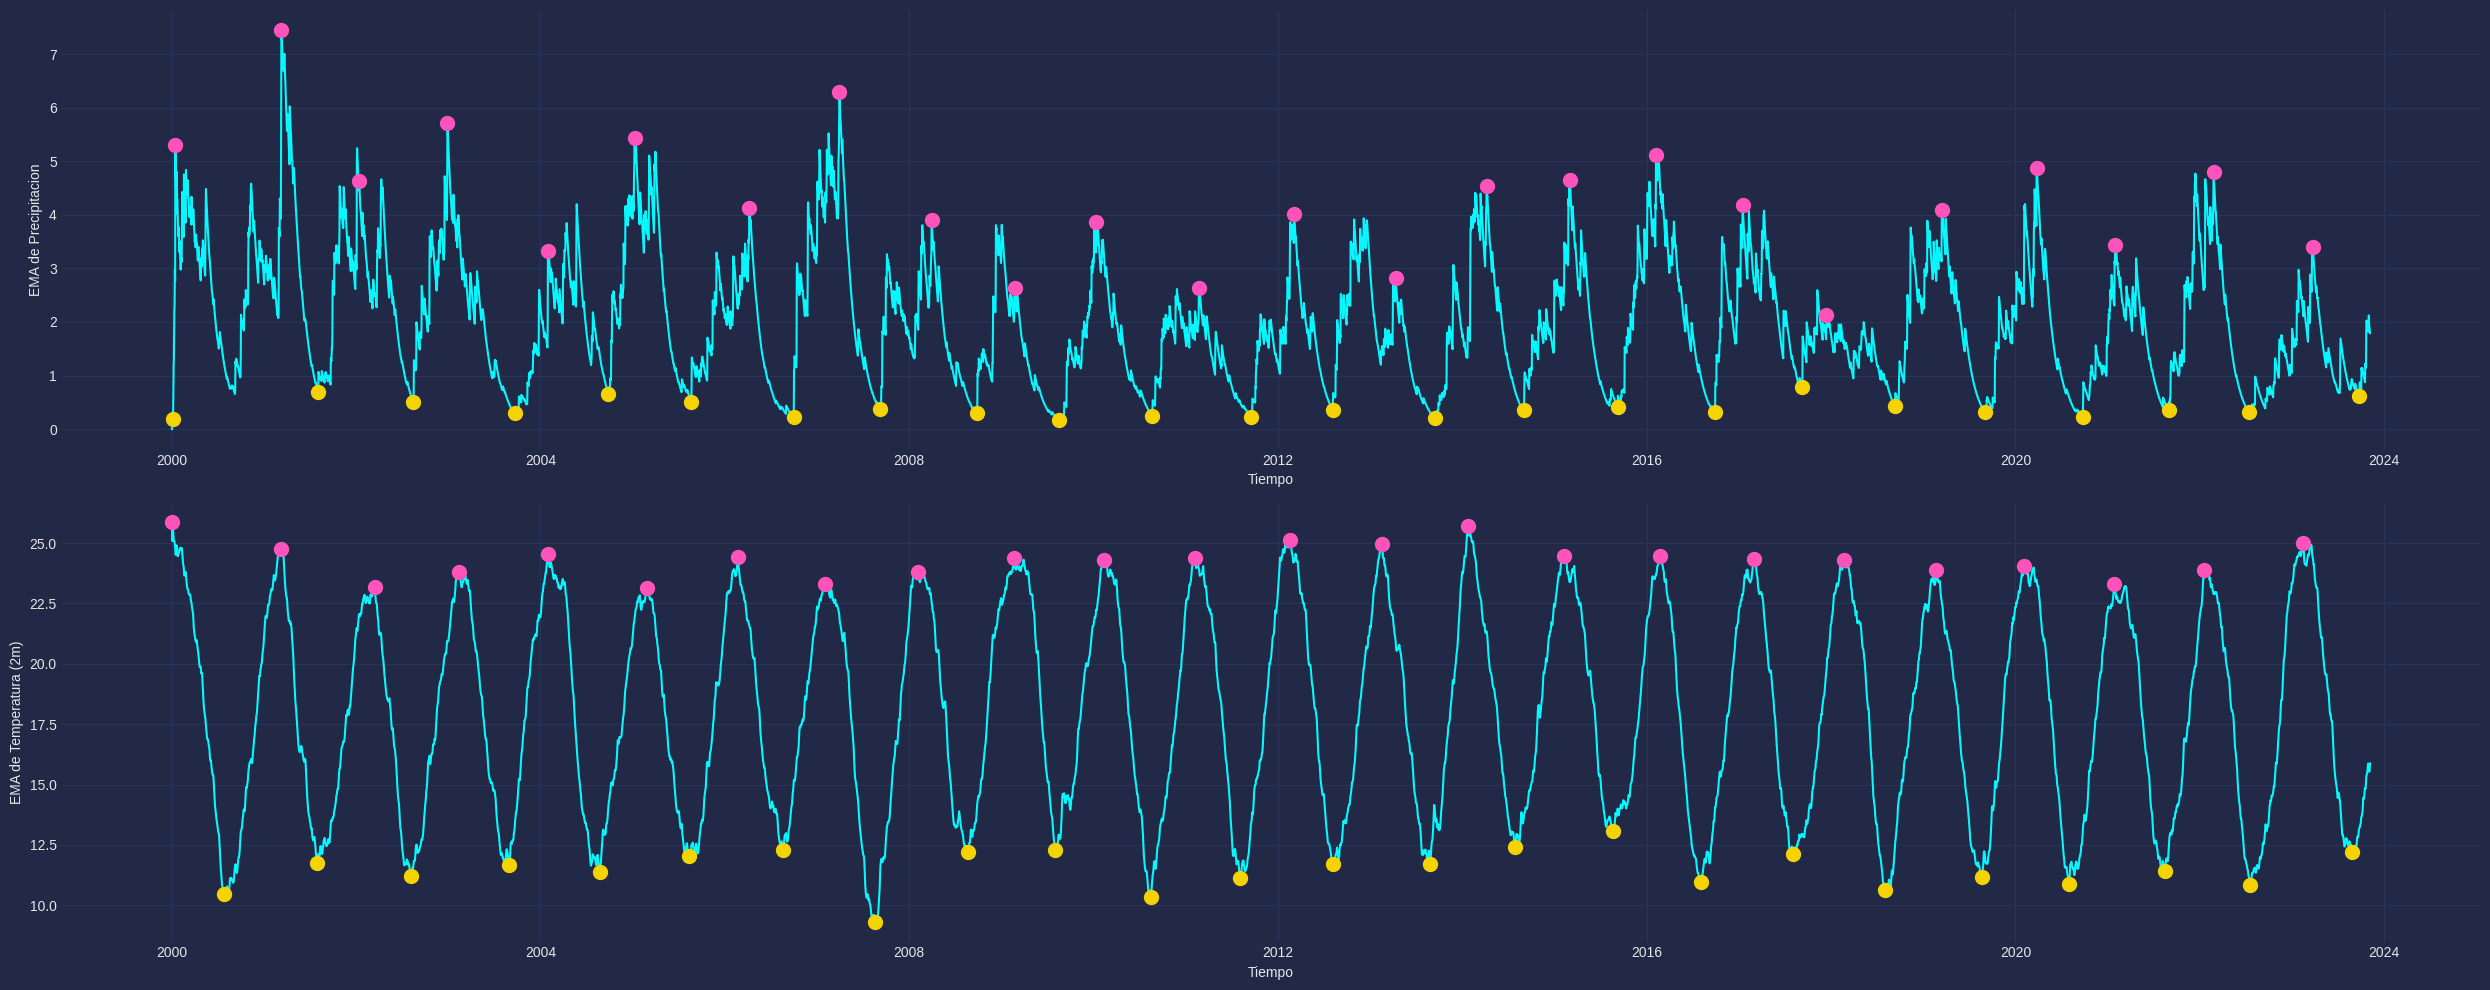

In [568]:
temp_picos_index, _ = find_peaks(sma_temp, distance=7*4*11, height=20)
temp_valles_index, _ = find_peaks(-sma_temp, distance=7*4*11)
picos_index, _ = find_peaks(sma_precipitation, distance=7*4*11, height=2)
valles_index, _ = find_peaks(-sma_precipitation, distance=7*4*11)

fig, axs = plt.subplots(2, 1, figsize=(25, 10))

plt.subplot(2,1,1)
sns.lineplot(y=sma_precipitation,  x=df["time"])
plt.plot(df.loc[picos_index, "time"], sma_precipitation[picos_index], "o", markersize=10)
plt.plot(df.loc[valles_index, "time"], sma_precipitation[valles_index], "o", markersize=10)
plt.ylabel("EMA de Precipitacion")
plt.xlabel("Tiempo")

plt.subplot(2,1,2)
sns.lineplot(y=sma_temp,  x=df["time"])
plt.plot(df.loc[temp_picos_index, "time"], sma_temp[temp_picos_index], "o", markersize=10)
plt.plot(df.loc[temp_valles_index, "time"], sma_temp[temp_valles_index], "o", markersize=10)
plt.ylabel("EMA de Temperatura (2m)")
plt.xlabel("Tiempo")

plt.tight_layout()

Como pudimos deducir, periodos de temperaturas bajas estan fuertemente relacionados con periodos de escasas precipitaciones y periodos de temperaturas altas estan relacionados con periodos de abundantes precipitaciones. Si lo pensamos es logico, la evaporacion del agua ocurre con temperaturas altas, a mayor temperatura mayor sera la facilidad de evaporacion del agua en el ambiente y esta misma evaporacion consigue condensarse en la atmosfera para posteriormente precipitarse sobre la superficie.

<img src="https://services.meteored.com/img/article/el-ciclo-del-agua-vives-inmerso-en-el-y-no-te-das-cuenta-3992-1_1280.jpg" width=700>

<IPython.core.display.Javascript object>

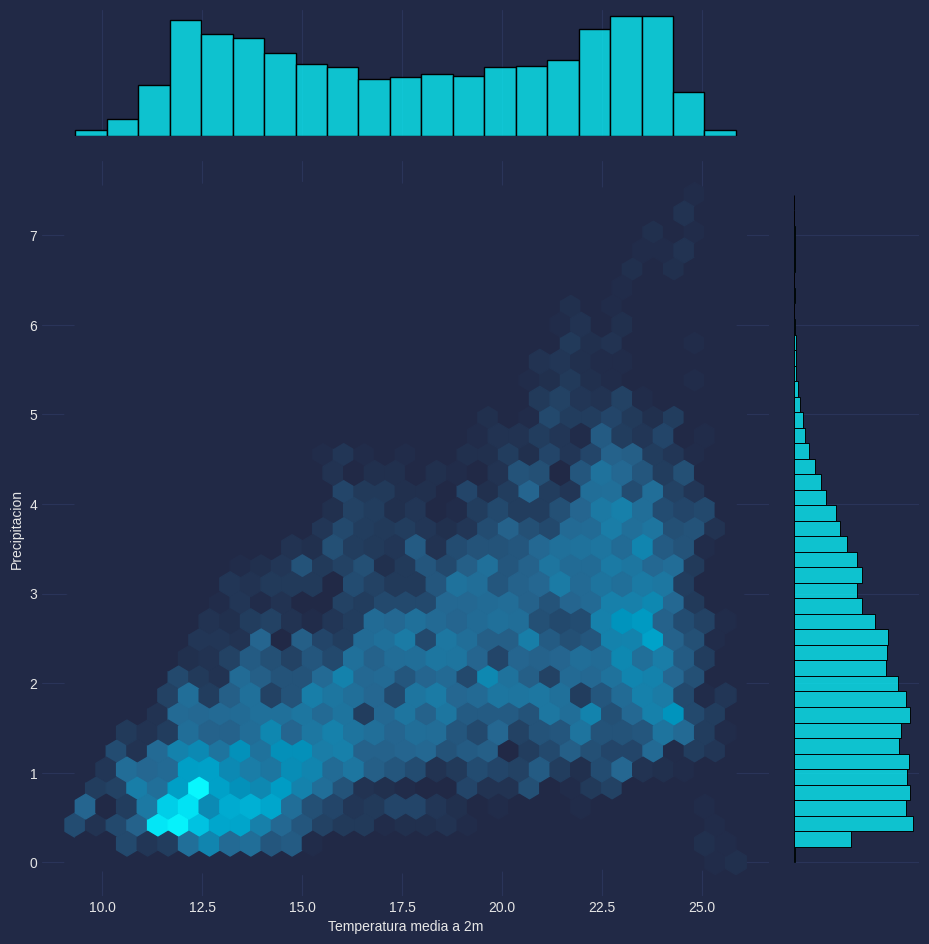

In [476]:
from matplotlib.colors import LinearSegmentedColormap

adjust_display()

ax=sns.jointplot(x=sma_temp, y=sma_precipitation, kind="hex")
ax.ax_joint._children[0].cmap=LinearSegmentedColormap.from_list(name="alex", colors=["#212946", "#256690", "#1a7da7", "#0094bd", "#00acd1", "#00c5e3", "#00def2", "#08f7fe"])
ax._figure._localaxes[0].xaxis.label._text="EMA de Temperatura media a 2m"
ax._figure._localaxes[0].yaxis.label._text="EMA de Precipitacion"
ax.figure.set_dpi(100)
ax.figure.set_size_inches(10, 10);

Por ultimo, podemos ver la relacion directa entre temperatura y precipitaciones, se ve claramente que precipitaciones abundanes se consiguen con temperaturas altas.

## Presion sobre la superficie

In [477]:
df_aux["date"] = pd.to_datetime(pd.to_datetime(df_aux["time"]).dt.date)
df_aux = df_aux[df_aux["date"] <= df["date"].max()].copy()
df["surface_pressure_mean"] = df_aux.groupby(by=["date"])["surface_pressure"].mean().values
df["surface_pressure_max"] = df_aux.groupby(by=["date"])["surface_pressure"].max().values
df["surface_pressure_min"] = df_aux.groupby(by=["date"])["surface_pressure"].min().values

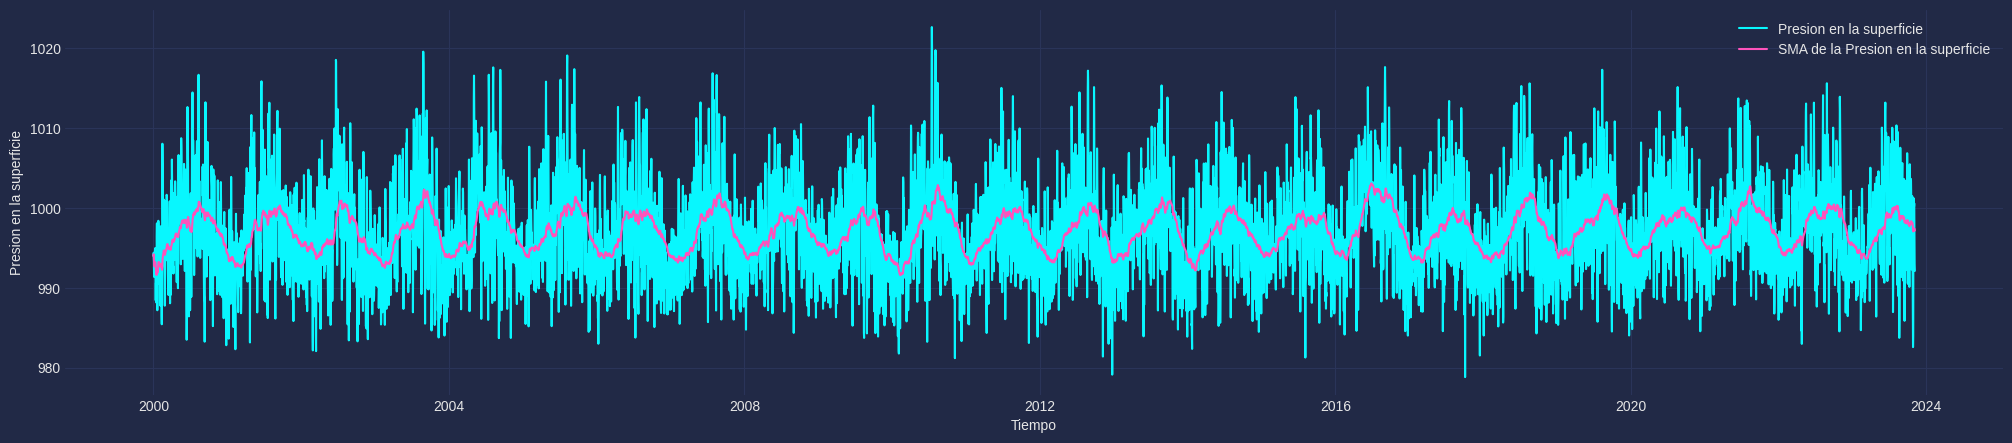

In [478]:
s_pressure = df["surface_pressure_mean"].ewm(7*6).mean()

plt.figure(figsize=(25, 5))
sns.lineplot(data=df, y="surface_pressure_mean", x="time", legend='brief', label="Presion en la superficie")
sns.lineplot(y=s_pressure,  x=df["time"], legend='brief', label="SMA de la Presion en la superficie");
plt.ylabel("Presion en la superficie")
plt.xlabel("Tiempo");

Nuevamente como procedimos con la temperatura, analizamos los maximos y minimos del SMA de la presion en la superficie, intentando encontrar alguna relacion con las precipitaciones.

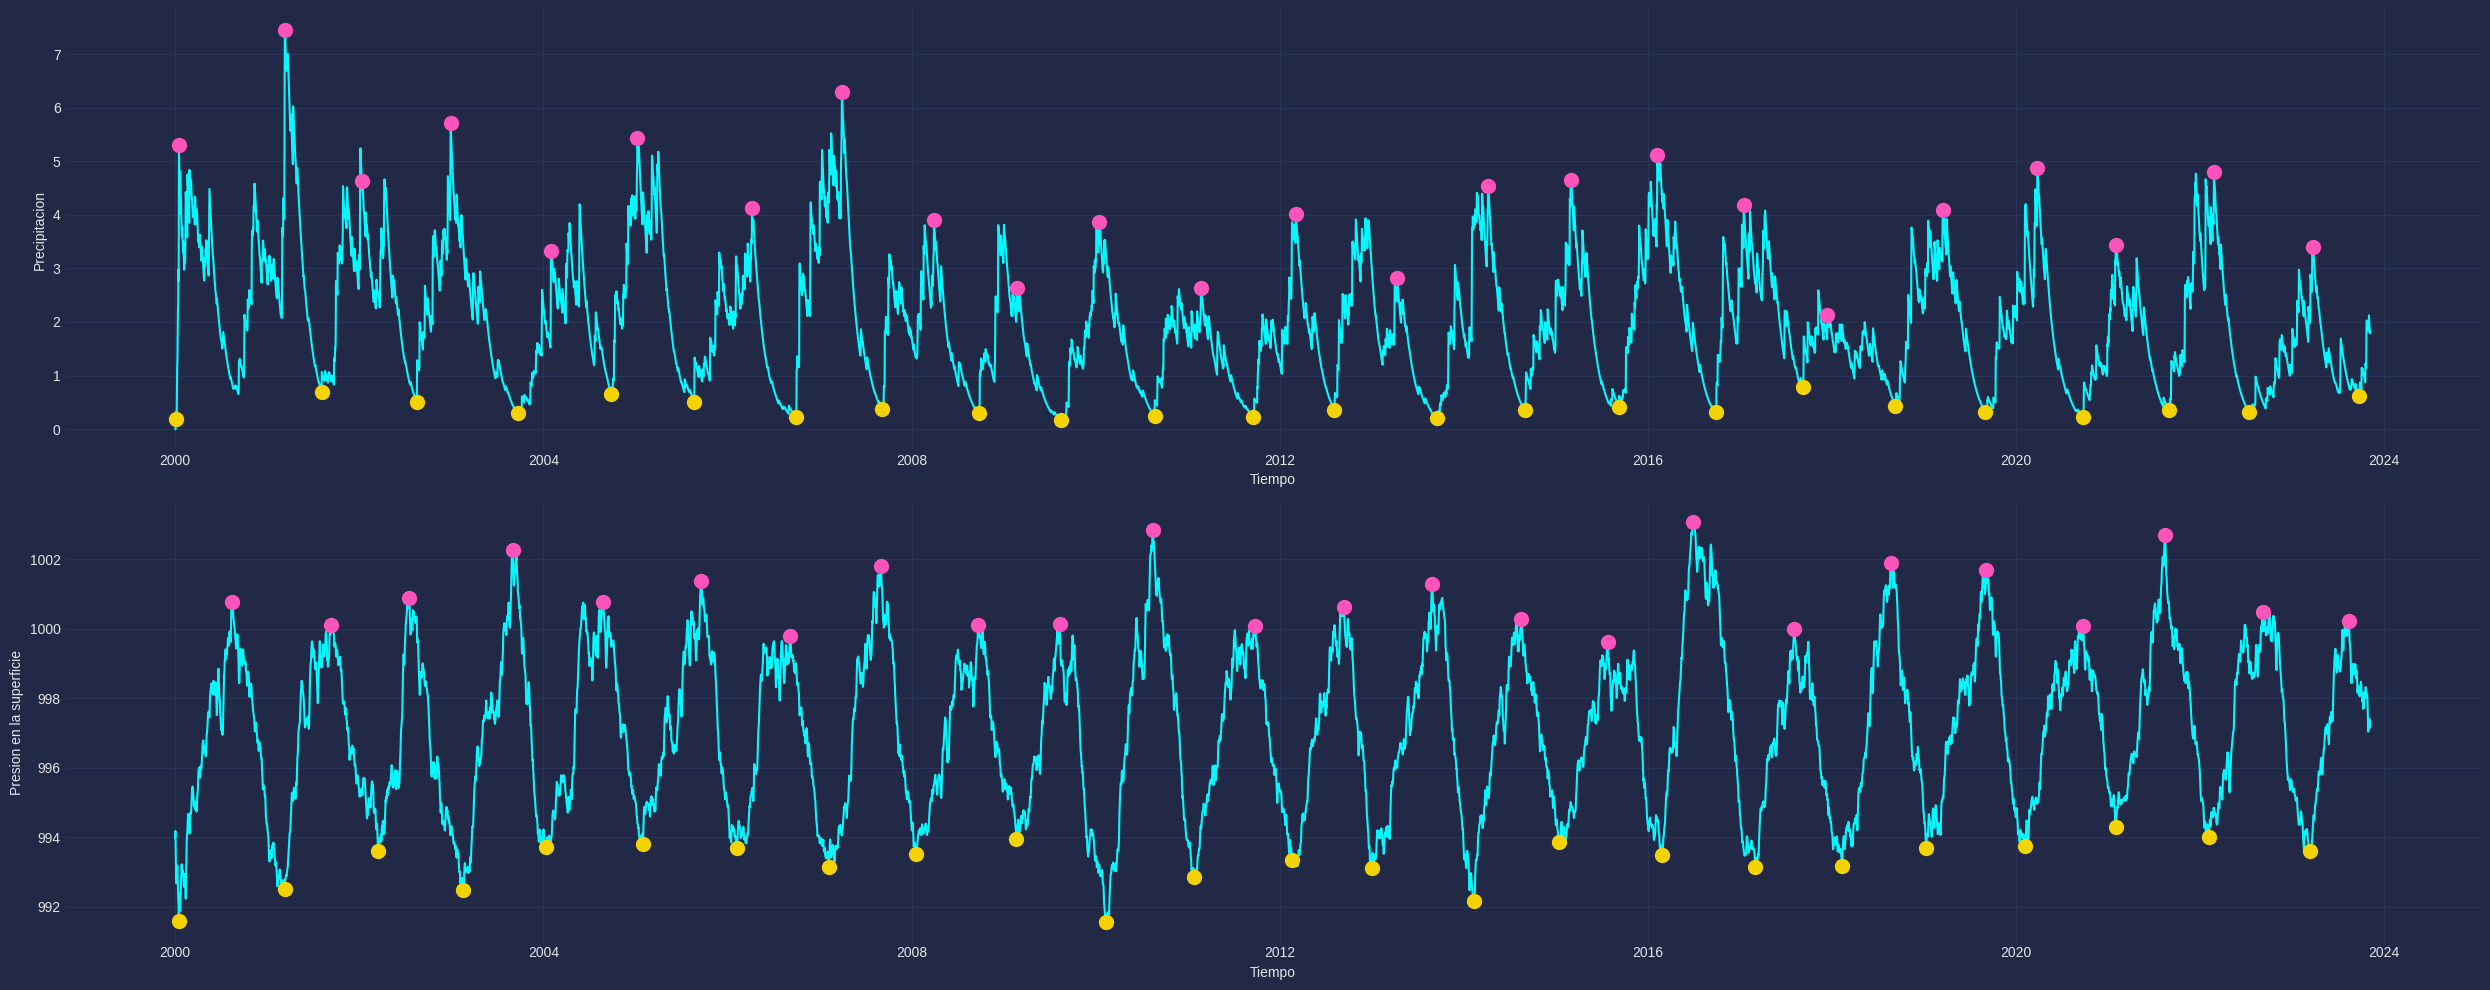

In [479]:
press_picos_index, _ = find_peaks(s_pressure, distance=7*4*11, height=997)
press_valles_index, _ = find_peaks(-s_pressure, distance=7*4*11)

picos_index, _ = find_peaks(sma_precipitation, distance=7*4*11, height=2)
valles_index, _ = find_peaks(-sma_precipitation, distance=7*4*11)

fig, axs = plt.subplots(2, 1, figsize=(25, 10))

plt.subplot(2,1,1)
sns.lineplot(y=sma_precipitation,  x=df["time"])
plt.plot(df.loc[picos_index, "time"], sma_precipitation[picos_index], "o", markersize=10)
plt.plot(df.loc[valles_index, "time"], sma_precipitation[valles_index], "o", markersize=10)
plt.ylabel("Precipitacion")
plt.xlabel("Tiempo")

plt.subplot(2,1,2)
sns.lineplot(y=s_pressure,  x=df["time"])
plt.plot(df.loc[press_picos_index, "time"], s_pressure[press_picos_index], "o", markersize=10)
plt.plot(df.loc[press_valles_index, "time"], s_pressure[press_valles_index], "o", markersize=10)
plt.ylabel("Presion en la superficie")
plt.xlabel("Tiempo")

plt.tight_layout()

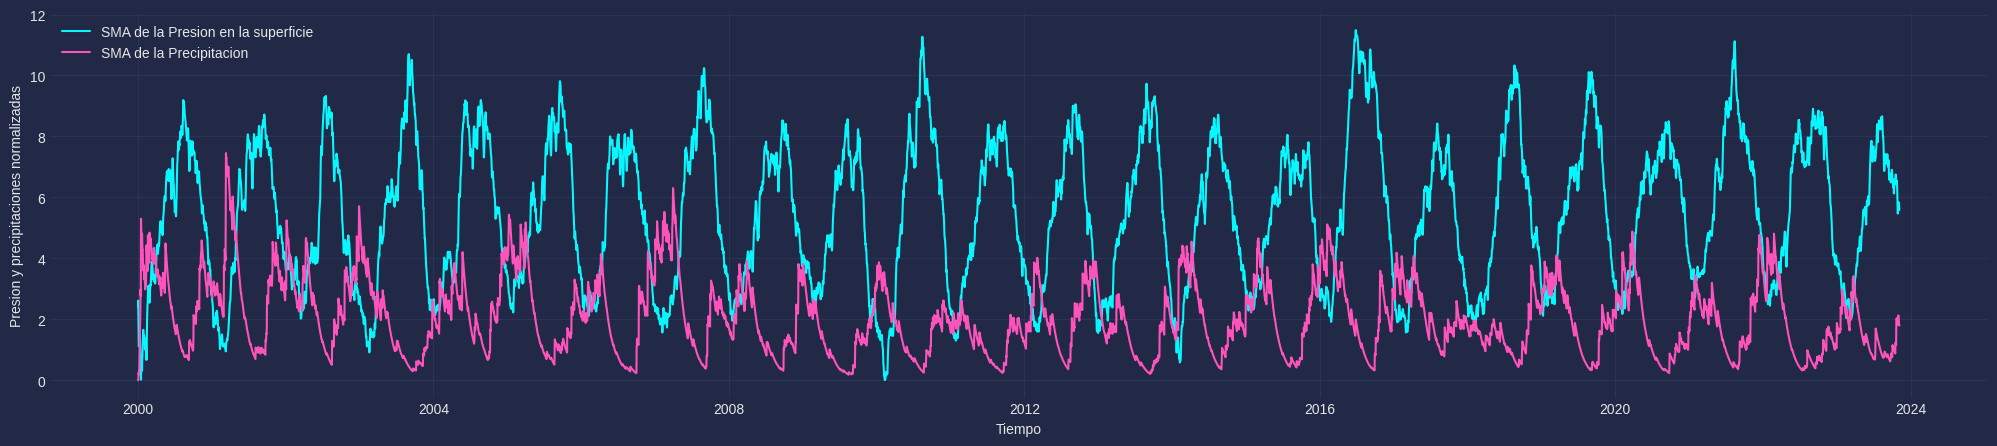

In [480]:
plt.figure(figsize=(25, 5))
sns.lineplot(y=s_pressure-s_pressure.min(),  x=df["time"], legend='brief', label="SMA de la Presion en la superficie");
sns.lineplot(y=sma_precipitation-sma_precipitation.min(),  x=df["time"], legend='brief', label="SMA de la Precipitacion");
plt.ylabel("Presion y precipitaciones normalizadas")
plt.xlabel("Tiempo");

Al igual que la temperatura, la presion superficial, que no es mas que la presion atmosferica pero medida al nivel del mar, influye sobre las precipitaciones, como podemos ver en temporadas donde la presion es relativamente mas baja las precipitaciones son mas abundantes, esto es debido a que al haber menor presion sobre una zona, el aire de los alrededores sera 'absorbido' con mayor facilidad.

<img src="https://services.meteored.com/img/article/alta-presion-de-bloqueo-que-significa-y-cuales-son-sus-consecuencias-1652995073963_1024.jpeg" width=700>

Esto sucede asi por que las presiones bajas indican zonas de aire menos concentrado y el aire de los alrededores, que estan en zonas de aire mas concentrado (presion alta), tendera a desplazarse a zonas de aire menos concentrado, arrastrando consigo vapor de agua, facilitando asi la formacion de nubosidades, y estas ultimas que ya no estaran formadas por vapor, si no, por agua se precipitaran posteriormente sobre la superficie. Para conocer mas sobre la presion atmosferica pueden seguir este [articulo de METEORED](https://www.meteored.cl/noticias/ciencia/desvendando-misterios-del-tiempo-atmosferico-que-son-las-altas-y-bajas-presiones.html#:~:text=Las%20bajas%20presiones%2C%20al%20contener,más%20baja%20sea%20la%20presión.).



<IPython.core.display.Javascript object>

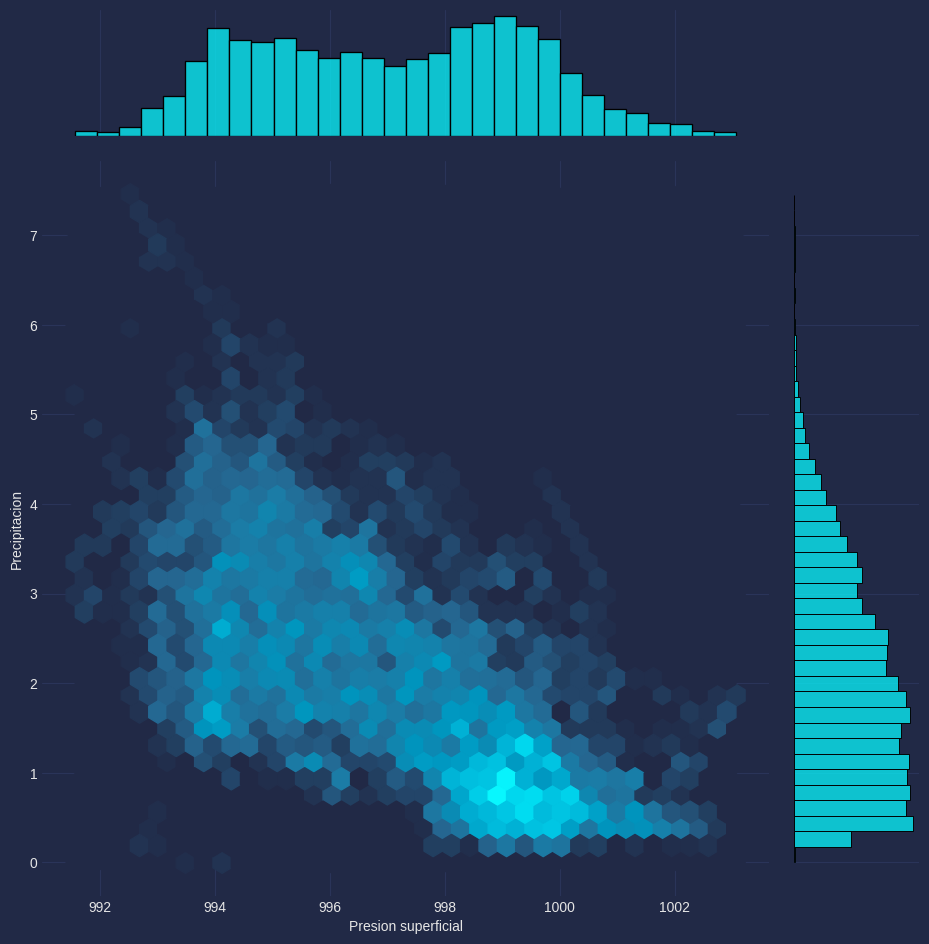

In [481]:
adjust_display()

ax=sns.jointplot(x=s_pressure, y=sma_precipitation, kind="hex")
ax.ax_joint._children[0].cmap=LinearSegmentedColormap.from_list(name="alex", colors=["#212946", "#256690", "#1a7da7", "#0094bd", "#00acd1", "#00c5e3", "#00def2", "#08f7fe"])
ax._figure._localaxes[0].xaxis.label._text="Presion superficial"
ax._figure._localaxes[0].yaxis.label._text="Precipitacion"
ax.figure.set_dpi(100)
ax.figure.set_size_inches(10, 10);

Al contrario de lo que sucede con la temperatura, cuando la presion es baja las precipitaciones que se presentan suelen ser mas altas.

## Entre altura, viento y nubes

In [482]:
df["windspeed_100m_max"] = df_aux.groupby(by=["date"])["windspeed_100m"].max().values
df["windspeed_100m_min"] = df_aux.groupby(by=["date"])["windspeed_100m"].min().values
df["windspeed_100m_mean"] = df_aux.groupby(by=["date"])["windspeed_100m"].mean().values

df["windspeed_10m_min"] = df_aux.groupby(by=["date"])["windspeed_10m"].min().values
df["windspeed_10m_mean"] = df_aux.groupby(by=["date"])["windspeed_10m"].mean().values

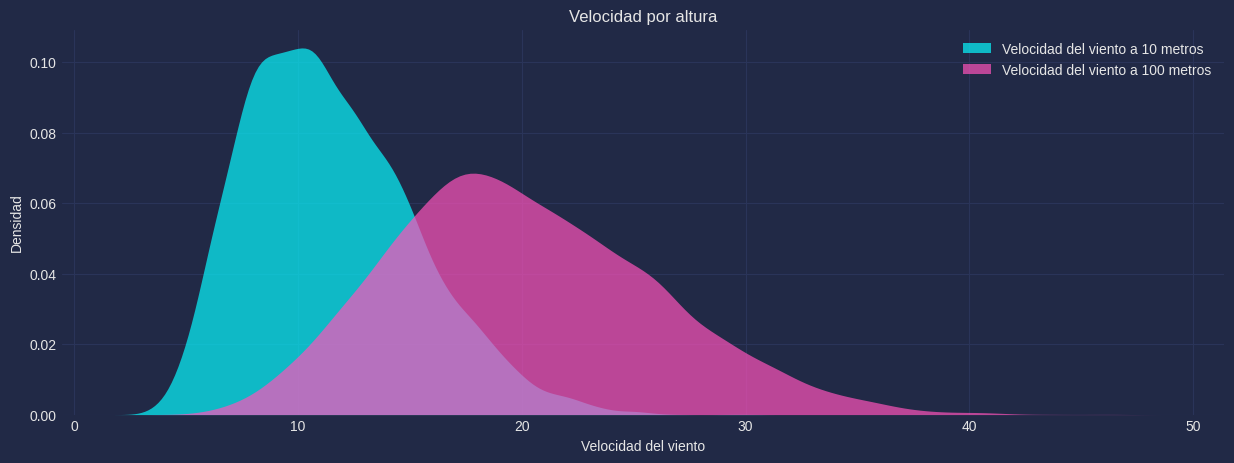

In [483]:
plt.figure(figsize=(15, 5))
sns.kdeplot(data=df, x="windspeed_10m_mean", fill=True, common_norm=False, alpha=.7, linewidth=0, legend='brief', label="Velocidad del viento a 10 metros")
sns.kdeplot(data=df, x="windspeed_100m_mean", fill=True, common_norm=False, alpha=.7, linewidth=0, legend='brief', label="Velocidad del viento a 100 metros")
plt.xlabel("Velocidad del viento")
plt.ylabel("Densidad")
plt.title("Velocidad por altura")
plt.legend();

In [484]:
df[["windspeed_10m_mean", "windspeed_100m_mean"]].describe().T

count       mean       std    min        25%        50%  \
windspeed_10m_mean   8711.0  11.449780  3.746456  3.625   8.577083  10.979167   
windspeed_100m_mean  8711.0  20.084854  5.888753  5.375  15.839583  19.525000   

                           75%        max  
windspeed_10m_mean   13.889583  29.725000  
windspeed_100m_mean  24.018750  46.141667

Como podemos ver cuanto mayor es la altura de medicion mayor es la velocidad media que podemos detectar, esto puede deberse a multiples factores, pero quizas la explicacion mas intuitiva es que el aire a mayor altura es probable que circule con mayor libertad y enfrentar menos obstaculos facilita un incremento de la velocidad. Y te preguntaras ¿Y esto como influye en las precipitaciones? Bueno es muy simple, si el aire circula facilmente sobre la atmosfera desplazando nubosidades y/o facilitando la acumulacion de vapores de agua, creara areas de alta concentracion de nubosidades que mas temprano que tarde se podrian precipitar.

<img src="https://drive.google.com/uc?export=view&id=13JKrLQG7weei0jmdB484WLCEztLb1F8Q" height=500>


En los estratos mas bajos de la atmosfera se concentran las nubosidades con altas concentraciones de agua, esto quizas sea debido a la densidad del agua con respecto a otros gases, por lo que seria razonable que en situaciones de altas precipitaciones el porcentaje de cielo cubierto por nubes sea mayor.

In [485]:
df["cloudcover_low_max"] = df_aux.groupby(by=["date"])["cloudcover_low"].max().values
df["cloudcover_low_min"] = df_aux.groupby(by=["date"])["cloudcover_low"].min().values
df["cloudcover_low_mean"] = df_aux.groupby(by=["date"])["cloudcover_low"].mean().values

df["cloudcover_mid_max"] = df_aux.groupby(by=["date"])["cloudcover_mid"].max().values
df["cloudcover_mid_min"] = df_aux.groupby(by=["date"])["cloudcover_mid"].min().values
df["cloudcover_mid_mean"] = df_aux.groupby(by=["date"])["cloudcover_mid"].mean().values

df["cloudcover_high_max"] = df_aux.groupby(by=["date"])["cloudcover_high"].max().values
df["cloudcover_high_min"] = df_aux.groupby(by=["date"])["cloudcover_high"].min().values
df["cloudcover_high_mean"] = df_aux.groupby(by=["date"])["cloudcover_high"].mean().values

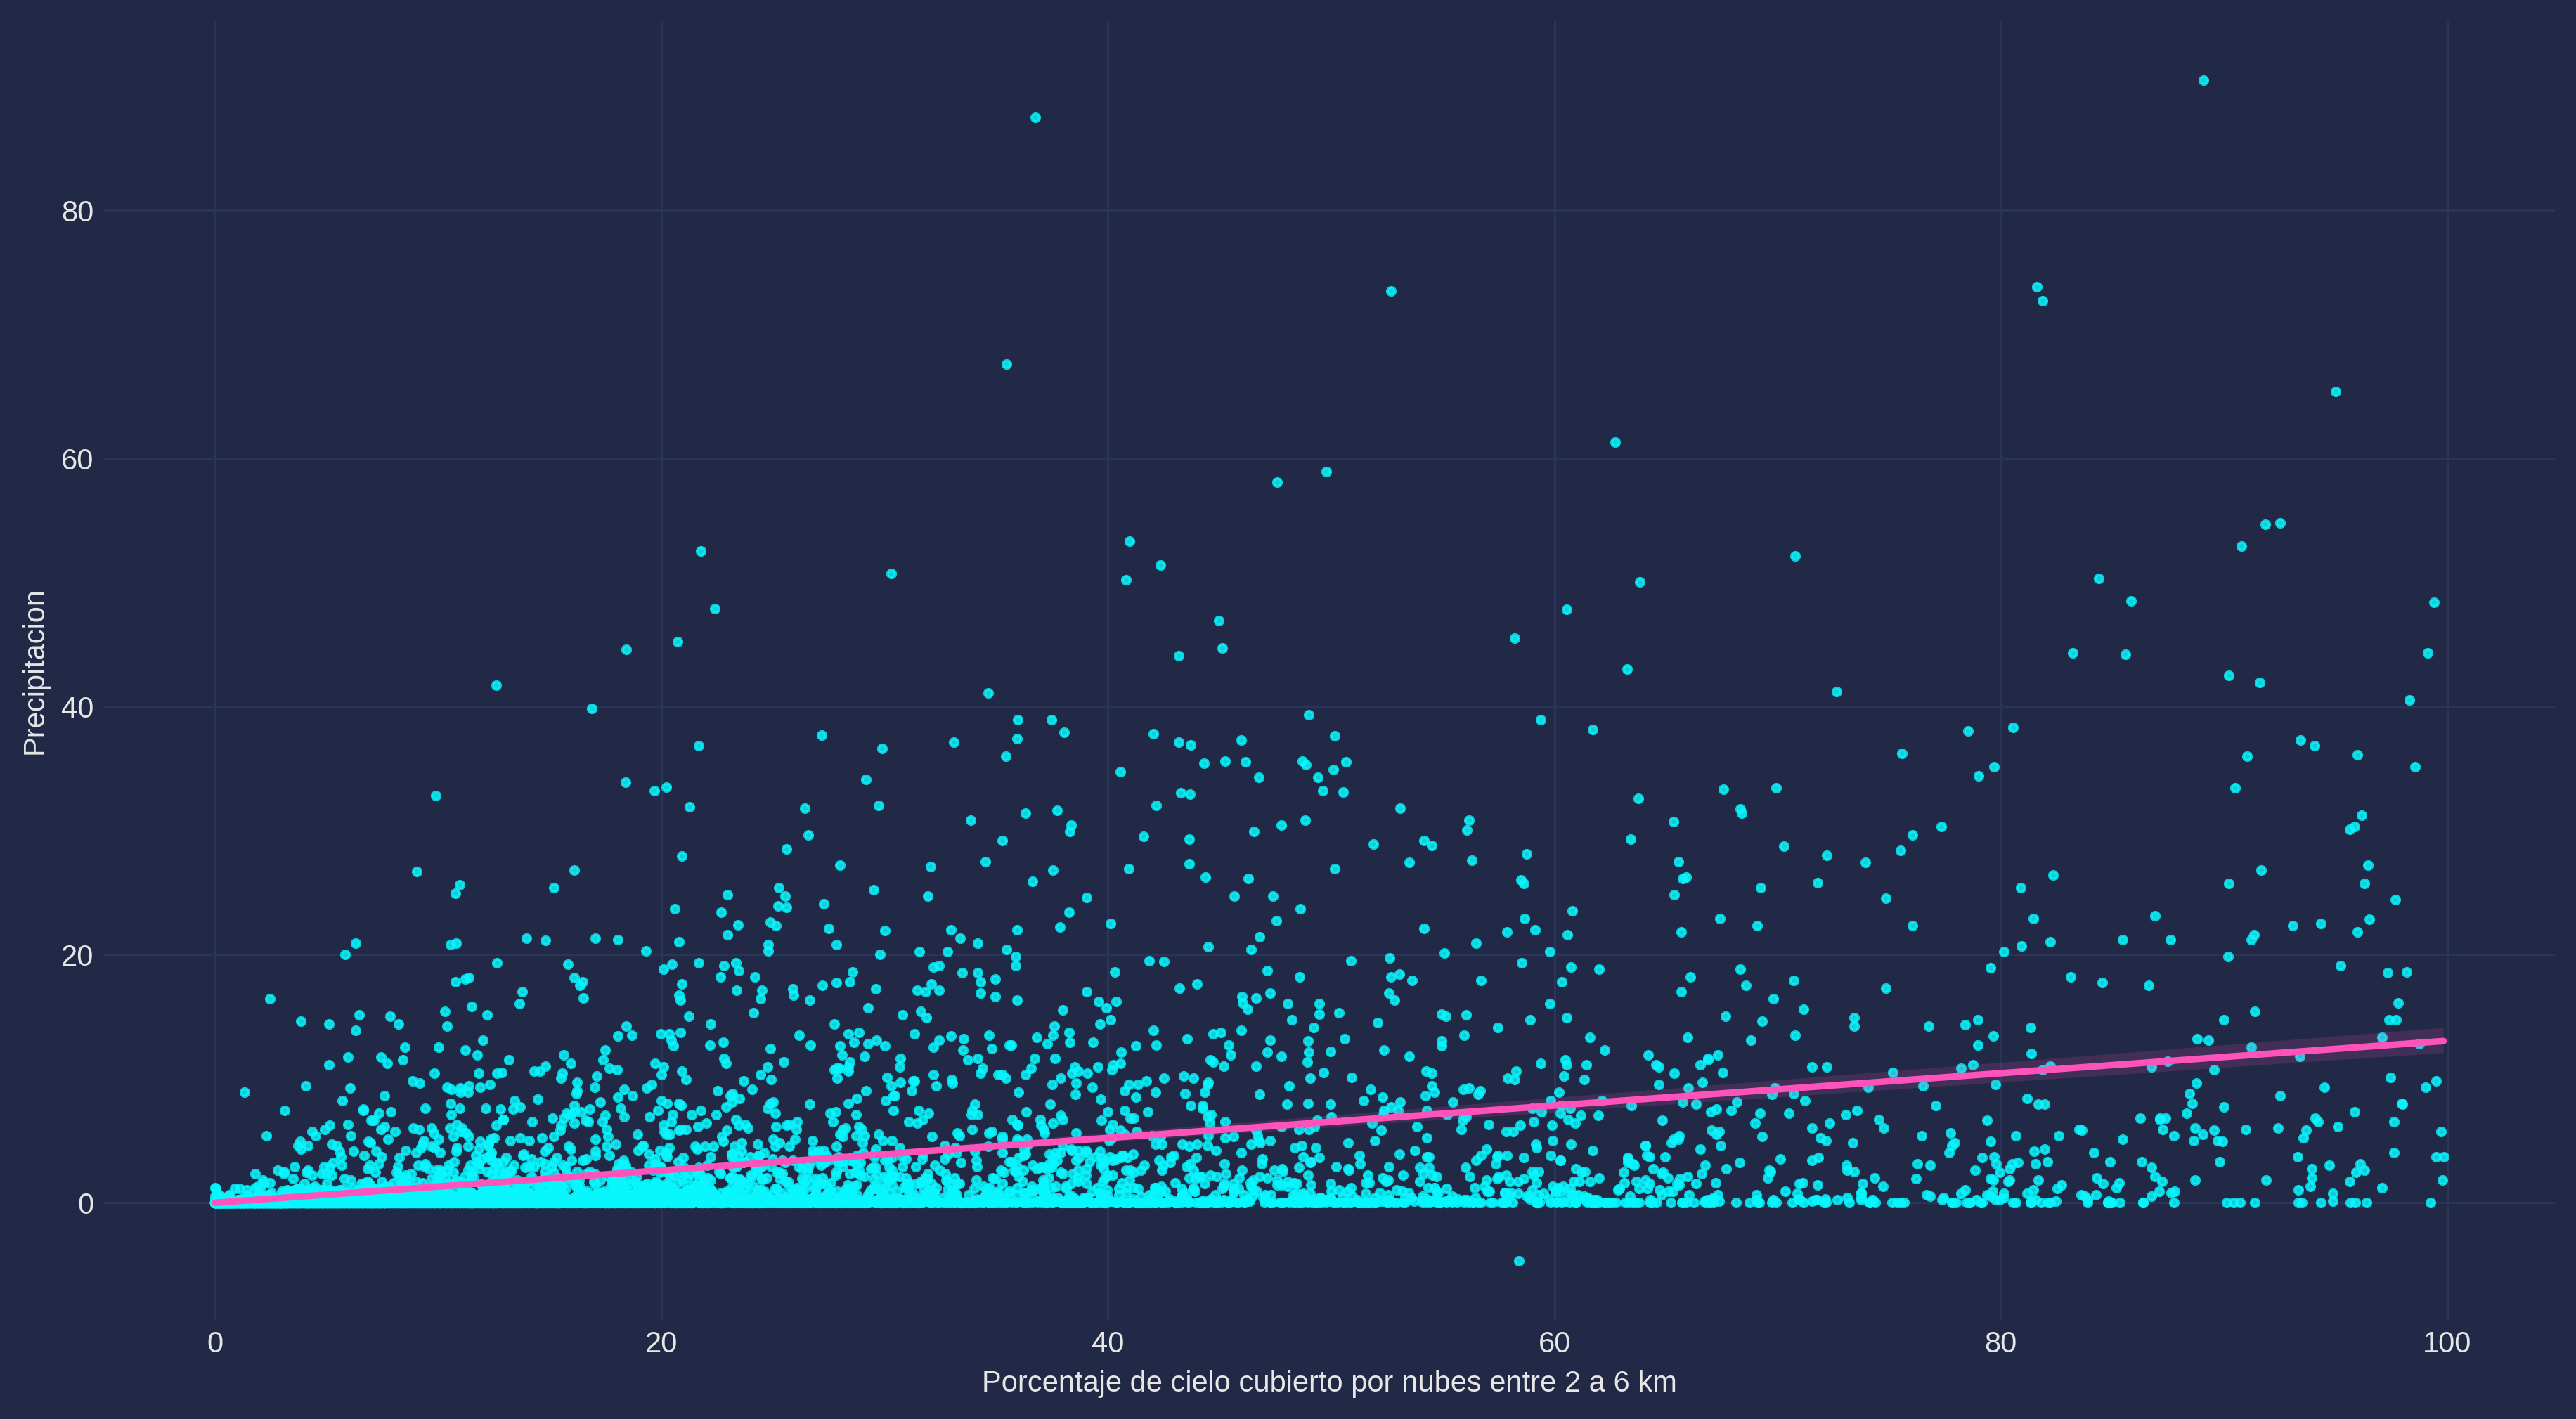

In [486]:
plt.figure(figsize=(15, 8), dpi=300)
sns.regplot(data=df, x="cloudcover_mid_mean", y="precipitation_sum", scatter_kws={"s": 7}, line_kws={"color": "C1"})
plt.xlabel("Porcentaje de cielo cubierto por nubes entre 2 a 6 km")
plt.ylabel("Precipitacion");

Vemos que hay una ligera tendencia a tener el cielo porcentualmente mas cubierto cuando hay mayor cantidad de precipitaciones. No es contraintuitivo. Y si vemos la velocidad del viento frente a las precipitaciones?



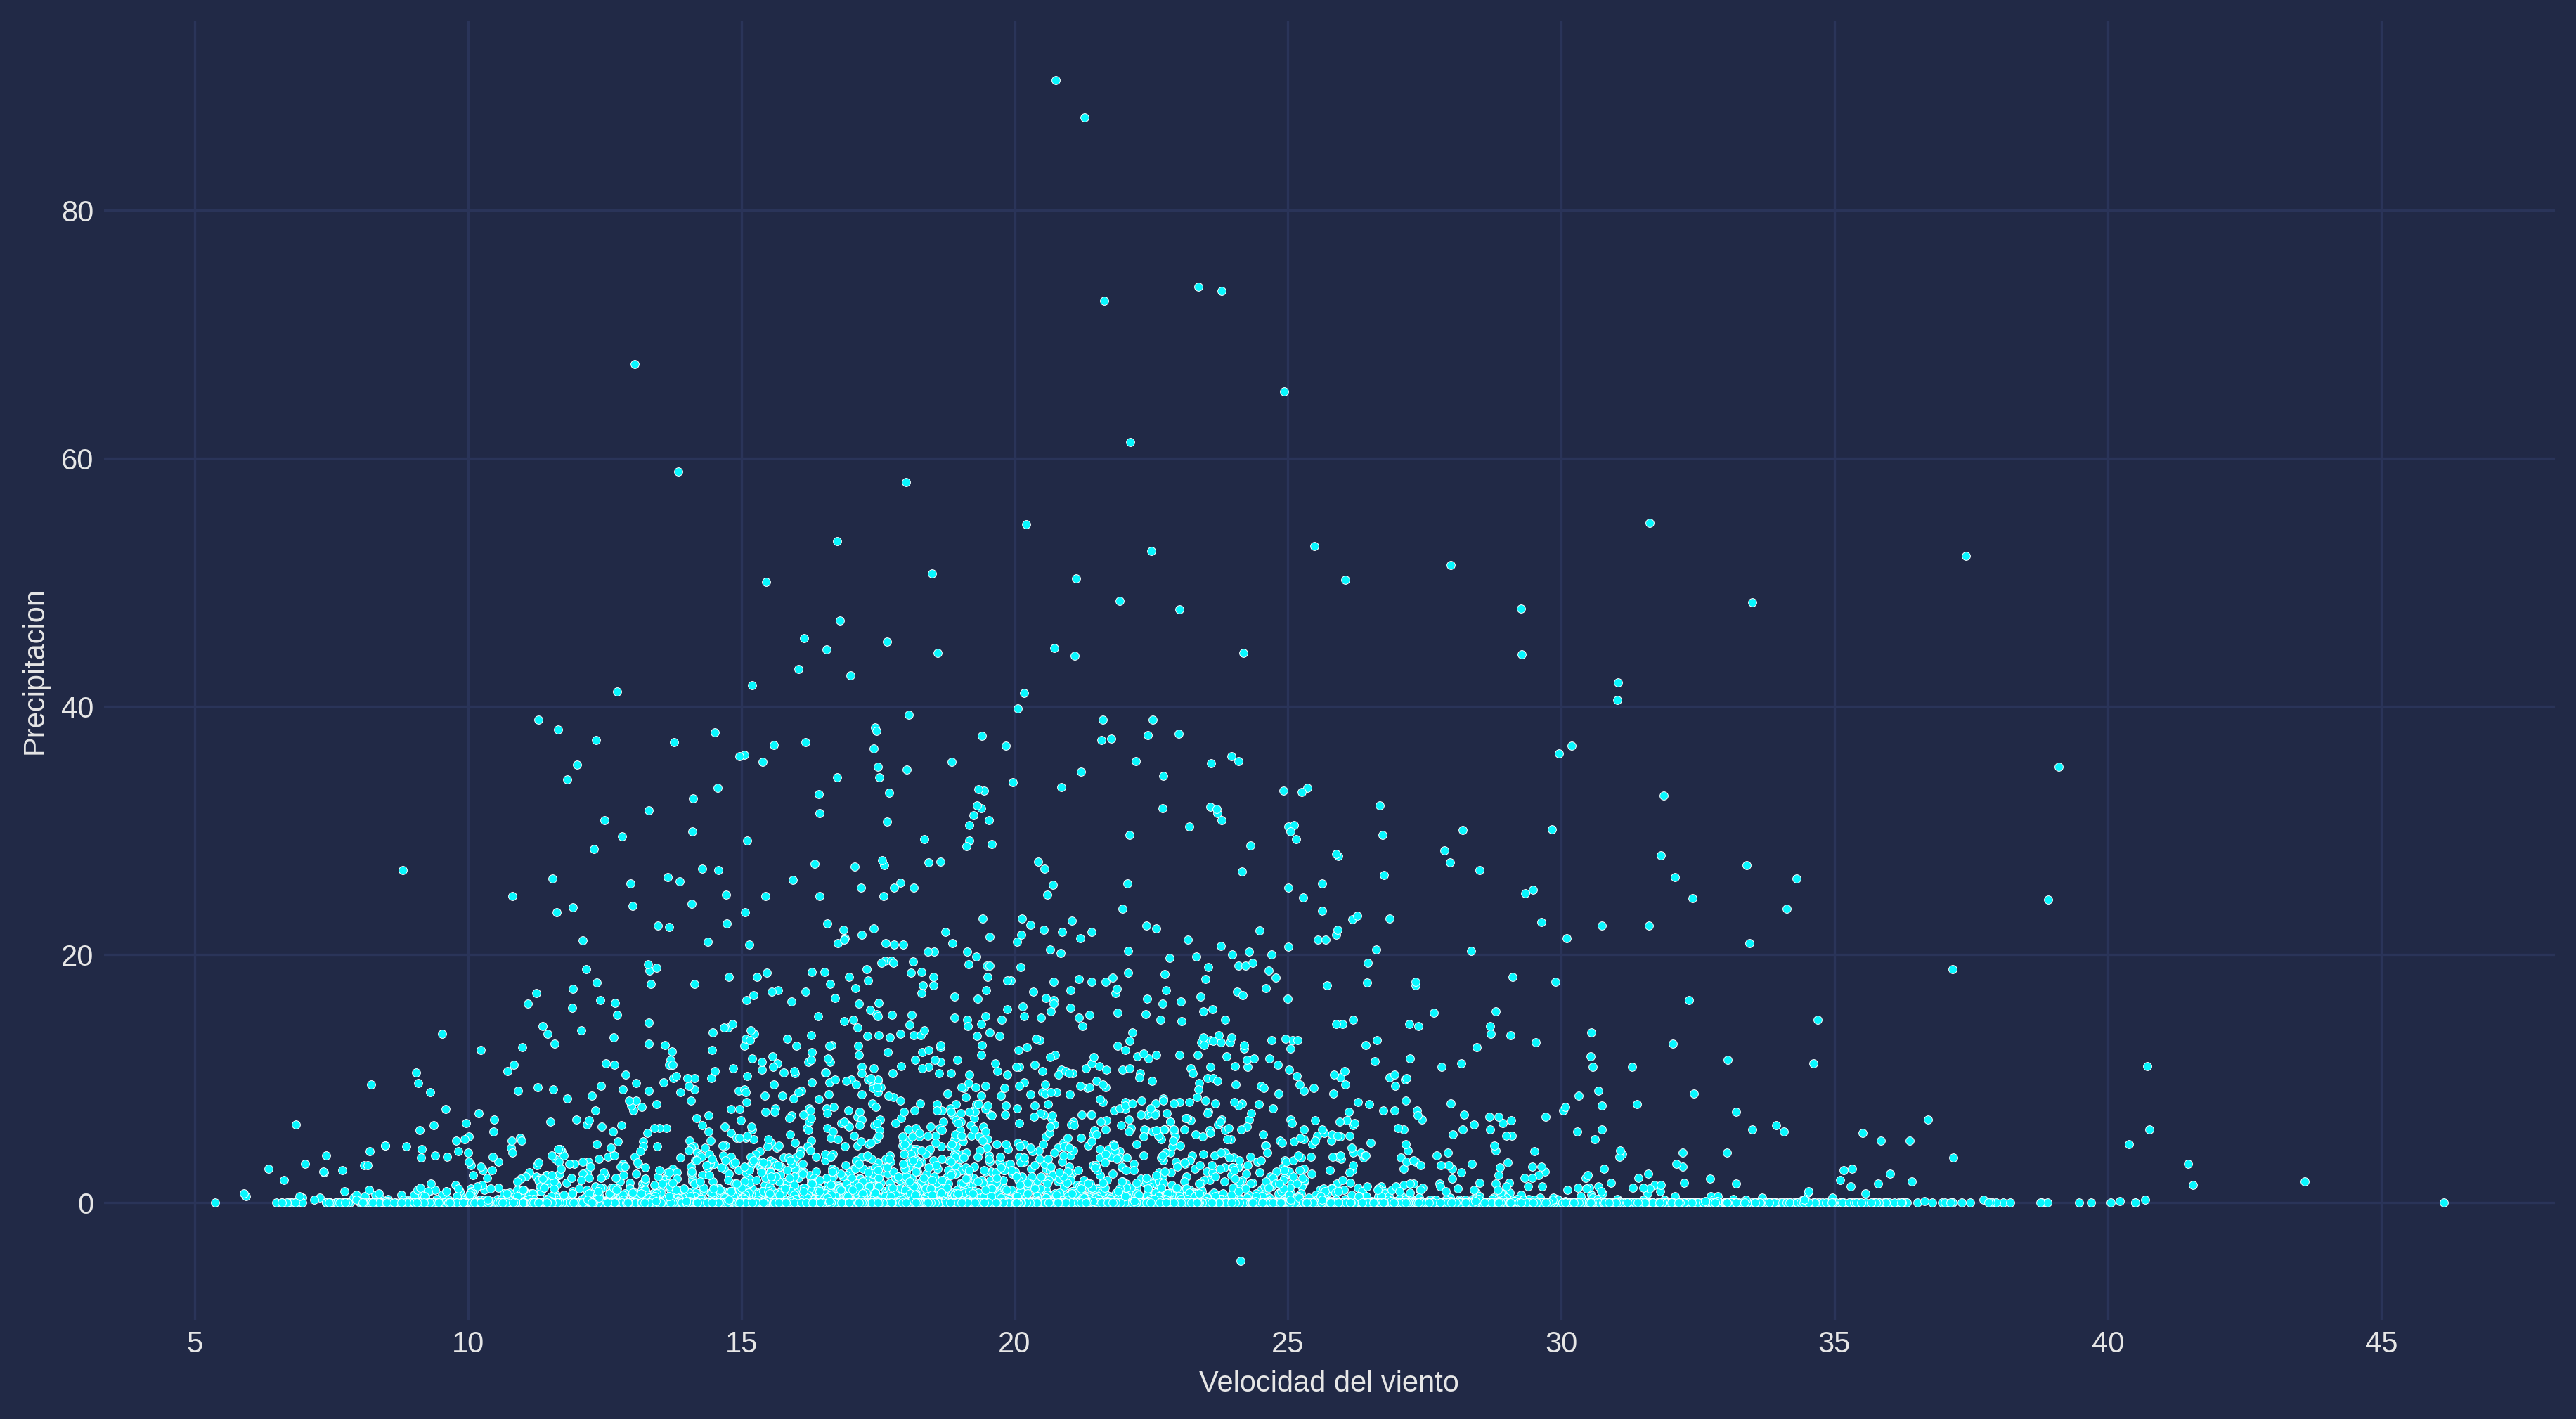

In [487]:
plt.figure(figsize=(15, 8), dpi=300)
sns.scatterplot(data=df, x="windspeed_100m_mean", y="precipitation_sum", s=8)
plt.xlabel("Velocidad del viento")
plt.ylabel("Precipitacion");

Bueno esto si es un poco contraintuitivo, pero si lo pensamos bien, asi como los fuertes vientos pueden arrastrar lluvias tambien pueden llevarselas, por lo que es logico pensar que en el momento de mayores precipitaciones la velocidad del viento sea menor una vez que la precipitacion esta establecida, se esperaria que la velocidad sea mayor hasta arrastrarla dentro del territorio donde se realiza el sondeo, pero no siempre es asi, la naturaleza juega sus propias reglas.

## Descomposicion estacional

<IPython.core.display.Javascript object>

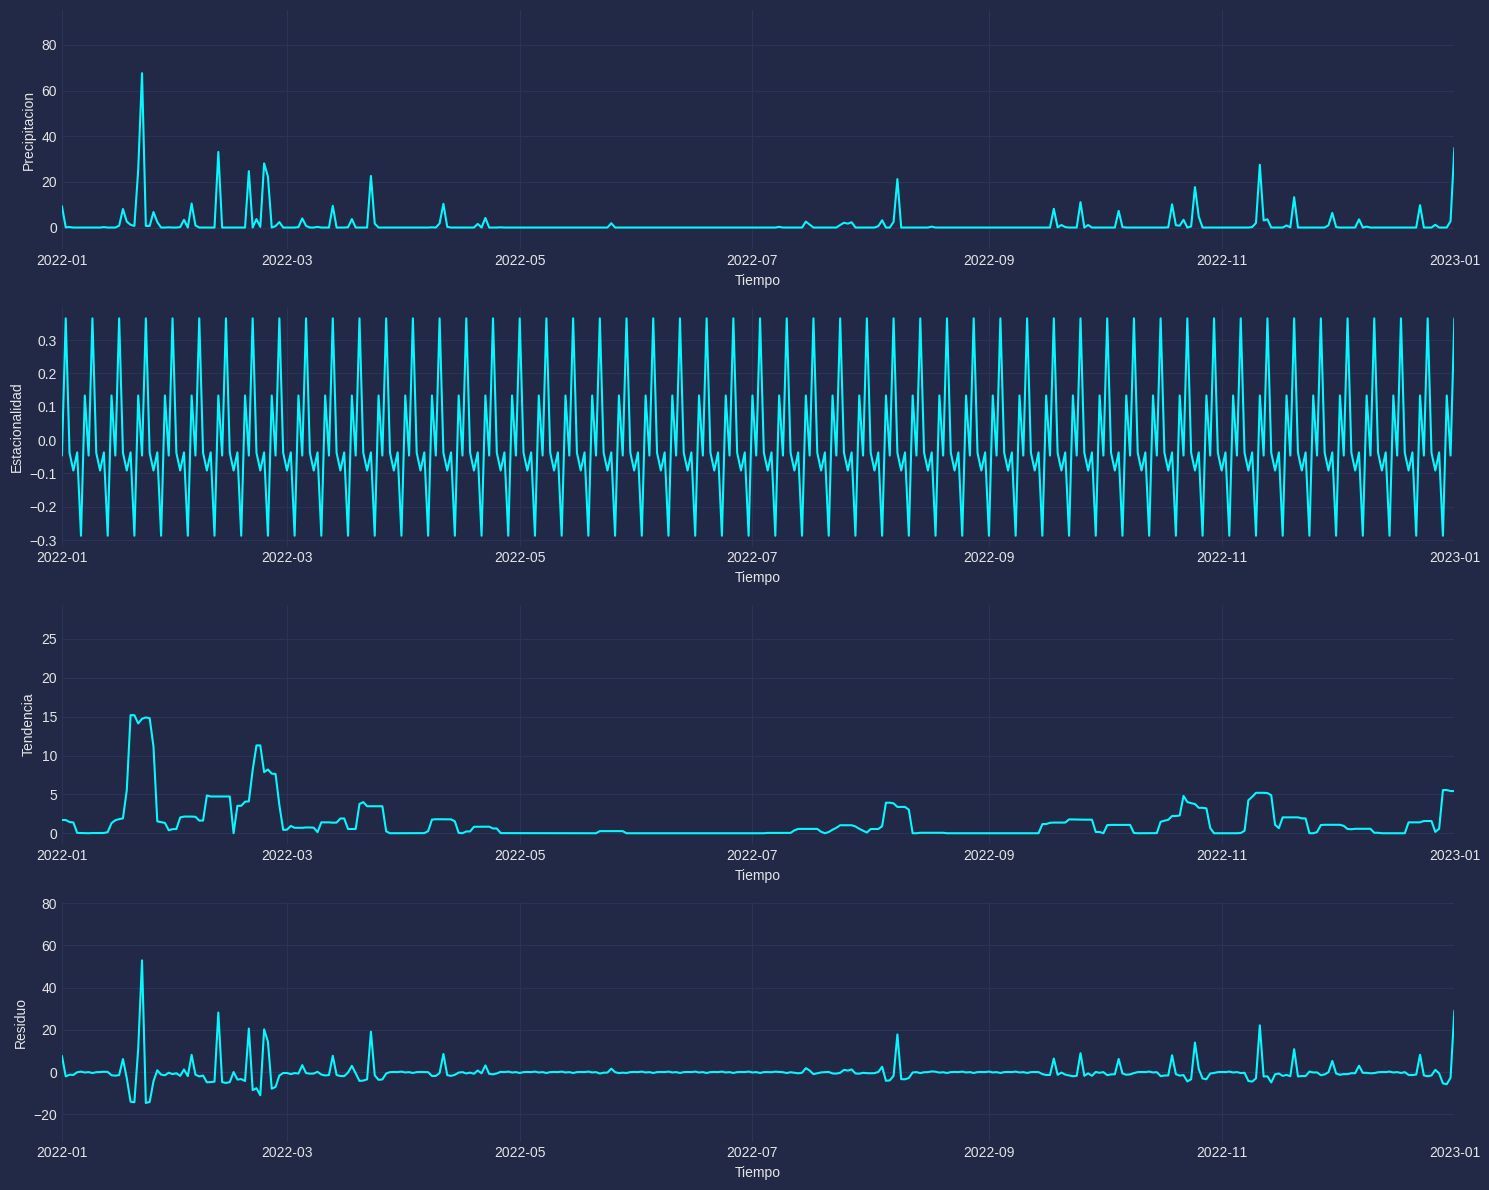

In [488]:
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime

adjust_display()

df.set_index('time', inplace=True)
stl = seasonal_decompose(df["precipitation_sum"])

fig, axs = plt.subplots(4, 1, figsize=(15, 12))

plt.subplot(4, 1, 1)
sns.lineplot(x=df.index, y=df.precipitation_sum)
plt.xlim(datetime.date(2022, 1, 1), datetime.date(2023, 1, 1))
plt.ylabel("Precipitacion")
plt.xlabel("Tiempo")

plt.subplot(4, 1, 2)
sns.lineplot(x=df.index, y=stl.seasonal)
plt.xlim(datetime.date(2022, 1, 1), datetime.date(2023, 1, 1))
plt.ylabel("Estacionalidad")
plt.xlabel("Tiempo")

plt.subplot(4, 1, 3)
sns.lineplot(x=df.index, y=stl.trend)
plt.xlim(datetime.date(2022, 1, 1), datetime.date(2023, 1, 1))
plt.ylabel("Tendencia")
plt.xlabel("Tiempo")

plt.subplot(4, 1, 4)
sns.lineplot(x=df.index, y=stl.resid)
plt.xlim(datetime.date(2022, 1, 1), datetime.date(2023, 1, 1))
plt.ylabel("Residuo")
plt.xlabel("Tiempo");

plt.tight_layout()

# Deteccion de outliers

In [489]:
df.describe()

weathercode  temperature_2m_max  temperature_2m_min  \
count  8711.000000         8711.000000         8711.000000   
mean     19.587533           23.164264           13.247893   
std      26.103505            6.603788            5.921051   
min       0.000000            2.400000           -9.600000   
25%       1.000000           18.000000            8.500000   
50%       2.000000           23.300000           13.500000   
75%      51.000000           28.300000           18.100000   
max      73.000000           41.400000           28.500000   

       temperature_2m_mean  apparent_temperature_max  \
count          8711.000000               8711.000000   
mean             17.905258                 22.753519   
std               6.110802                  8.566220   
min              -1.900000                 -0.800000   
25%              12.900000                 15.900000   
50%              18.100000                 22.800000   
75%              22.800000                 29.500000   
max              34.400000                 43.600000   

       apparent_temperature_min  apparent_temperature_mean  precipitation_sum  \
count               8711.000000                8711.000000        8711.000000   
mean                  11.803869                  16.859936           2.017288   
std                    7.455832                   7.735340           6.223068   
min                  -14.500000                  -6.200000          -4.700000   
25%                    5.800000                  10.500000           0.000000   
50%                   11.700000                  16.800000           0.000000   
75%                   17.800000                  23.200000           0.500000   
max                   30.700000                  34.700000          90.500000   

         rain_sum  snowfall_sum  precipitation_hours  windspeed_10m_max  \
count  8711.00000   8711.000000          8711.000000        8711.000000   
mean      2.01761      0.000932             2.038802          16.818253   
std       6.22303      0.055211             4.109786           4.888652   
min       0.00000      0.000000             0.000000           5.200000   
25%       0.00000      0.000000             0.000000          13.200000   
50%       0.00000      0.000000             0.000000          16.400000   
75%       0.50000      0.000000             2.000000          19.800000   
max      90.50000      3.920000            24.000000          42.900000   

       windgusts_10m_max  winddirection_10m_dominant  shortwave_radiation_sum  \
count        8711.000000                 8711.000000              8711.000000   
mean           35.533601                  103.822638                17.851174   
std            10.314340                   87.681924                 8.222598   
min            12.600000                    0.000000                 0.860000   
25%            28.100000                   33.000000                11.490000   
50%            34.900000                   65.000000                16.960000   
75%            42.100000                  167.000000                24.670000   
max            90.400000                  360.000000                34.610000   

       et0_fao_evapotranspiration    hour          day        month  \
count                 8711.000000  8711.0  8711.000000  8711.000000   
mean                     3.909441     0.0    15.721042     6.491103   
std                      2.112624     0.0     8.803481     3.436133   
min                      0.200000     0.0     1.000000     1.000000   
25%                      2.120000     0.0     8.000000     4.000000   
50%                      3.580000     0.0    16.000000     7.000000   
75%                      5.560000     0.0    23.000000     9.000000   
max                     11.640000     0.0    31.000000    12.000000   

              year         week      quarter  day_of_year  day_of_week  \
count  8711.000000  8711.000000  8711.000000  8711.000000  8711.000000   
mean   2011.426357 

Antes de iniciar con la deteccion, a priori podemos decir que no pueden haber valores negativos de precipitacion, ya que esto es inconsistente con la realidad, en todo caso el valor minimo puede ser 0.

In [490]:
df[df["precipitation_sum"] < 0]["precipitation_sum"] = 0

<ipython-input-490-729a64e5a05f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df["precipitation_sum"] < 0]["precipitation_sum"] = 0


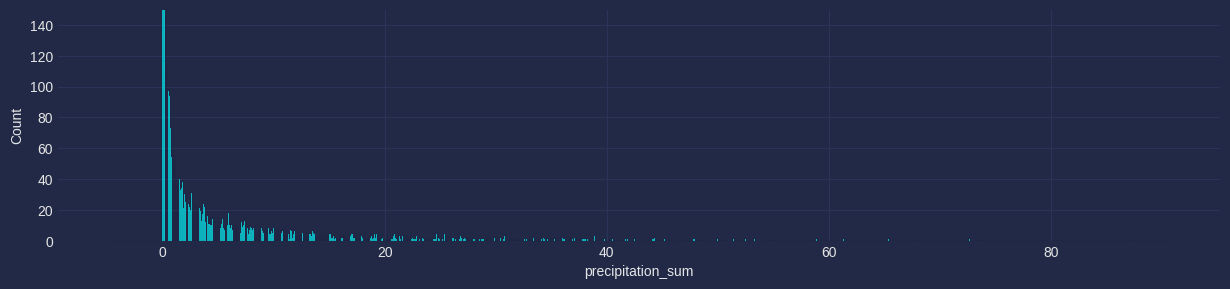

In [491]:
plt.figure(figsize=(15, 3))
sns.histplot(df["precipitation_sum"])
plt.ylim(0, 150);

### Deteccion con arboles de clasificación (CART)
Podemos utilizar el poder y la solidez de los árboles de decisión para identificar valores atípicos/anomalías en datos de series temporales.

La idea principal, que es diferente de otros métodos populares de detección de valores atípicos, es que Isolation Forest identifica explícitamente anomalías en lugar de perfilar puntos de datos normales. Isolation Forest, como cualquier método de conjunto de árboles, se basa en árboles de decisión.

In [492]:
from sklearn.ensemble import IsolationForest

scaler = StandardScaler()
np_scaled = scaler.fit_transform(df[["precipitation_sum"]])
model = IsolationForest(contamination=0.005)
model.fit(np_scaled)

IsolationForest(contamination=0.005)

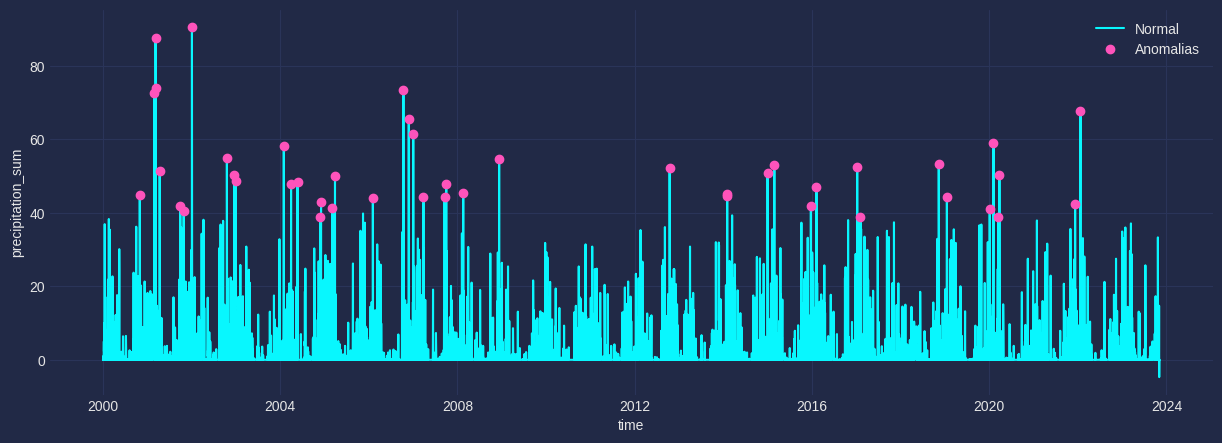

In [493]:
outliers = pd.DataFrame(data={"time":df.index})
outliers["precipitation_sum"] = df["precipitation_sum"].values
outliers["anomalies"] = model.predict(np_scaled)

anomalies = outliers[outliers["anomalies"] == -1] #Anomalias

plt.figure(figsize=(15,5))
sns.lineplot(x=df.index, y=df["precipitation_sum"], legend="brief", label = 'Normal')
plt.plot(anomalies.time, anomalies["precipitation_sum"], label='Anomalias', marker="o", linestyle="")
plt.legend();

Una vez detectados estos puntos anomalos, podemos reacondiconarlos para lograr

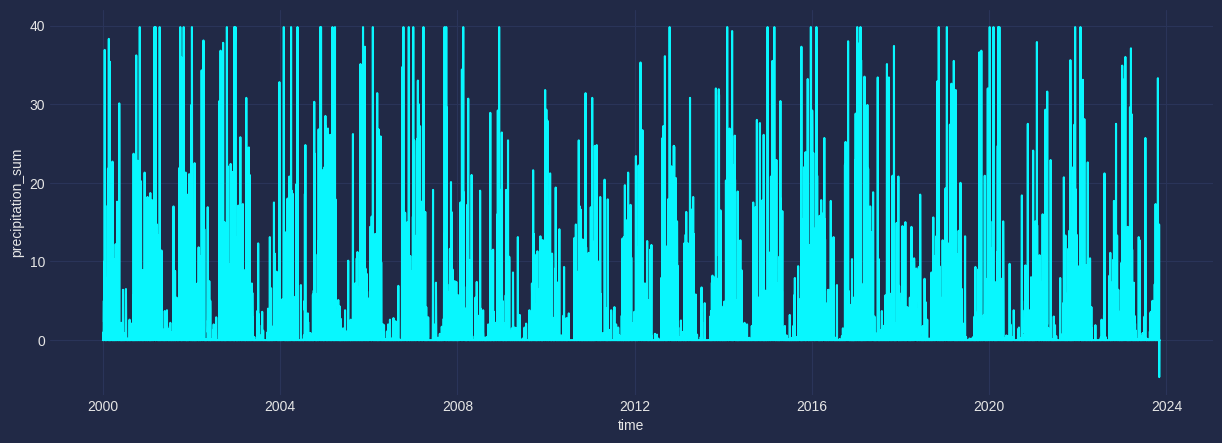

In [494]:
outliers.loc[outliers["anomalies"] == -1, "precipitation_sum"] = outliers[outliers["anomalies"] != -1].precipitation_sum.max()

plt.figure(figsize=(15,5))
sns.lineplot(x=outliers.time, y=outliers["precipitation_sum"]);

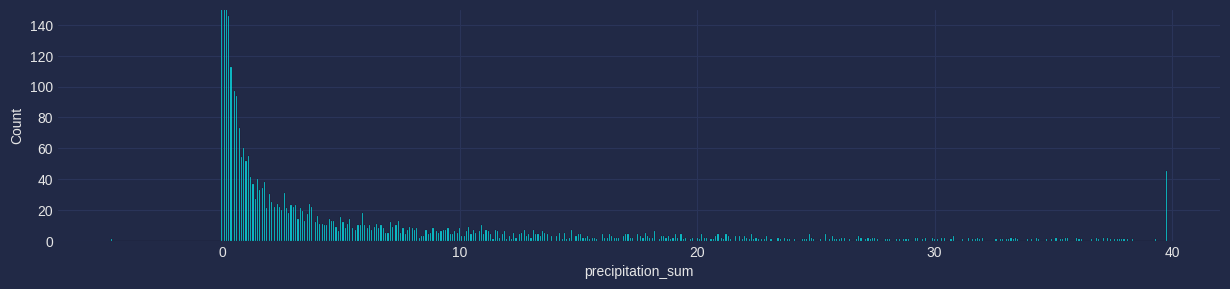

In [495]:
plt.figure(figsize=(15, 3))
sns.histplot(outliers["precipitation_sum"])
plt.ylim(0, 150);

In [496]:
df_ = df.copy()
df_["precipitation_sum"] = outliers["precipitation_sum"].values

# Eliminando columnas redundantes

## Date y time
Esta columna esta implicita en "time" y desfragmentada en otras variables tales como "day", "month" y "year", entre otros, por lo que conservaremos solamente "time" ya que nos sirve como indice.

In [497]:
df_.drop(["date"], axis=1, inplace=True)

## Caracteristicas relacionadas directamente a nuestro target
Nuestro target es la prediccion de precipitaciones, hay una variable que nos es util para esto y esta denominada como "precipitation_sum" que es equivalente a la suma de "rain_sum" y "snowfall_sum" por lo que estas variables deberian descartarse ya que a priori estan contenidas por nuestro target.

Por otro lado, "weathercode" es el [WMO Code](https://www.jodc.go.jp/data_format/weather-code.html) que nos indica a travez de una serie de codigos la condicion climatica presente, por lo que este codigo nos adelanta de antemano informacion que buscamos predecir (ver por ejemplo "Present Weather (WMO Code 4677) - Code 54" en el enlace anterior) por lo que debemos descartarlo tambien.

In [498]:
df_.drop([
    "rain_sum",
    "snowfall_sum",
    #"weathercode"
    ], axis=1, inplace=True)

# Separacion en set de datos de entrenamiento, validation y prueba

Tengamos en cuenta que estamos en presencia de una set de datos del tipo Serie temporal, por lo que la division del set no puede romper la cronologia de eventos, por lo que consideraremos los ultimos 12 meses como set de prueba y el resto se utilizara para entrenamiento.

In [499]:
#Cada registro representa una hora, por lo que extraer los ultimos 2400 registros es equivalente a extraer los ultimos 100 dias.
dias = 365*4 #Aproximadamente 6 meses
test_size = dias

train = df_[0:-test_size].copy()
test = df_[-test_size:].copy()

valid = test[0:-test_size//2].copy()
test = test[-test_size//2:].copy()

train.shape, valid.shape, test.shape

((7251, 43), (730, 43), (730, 43))

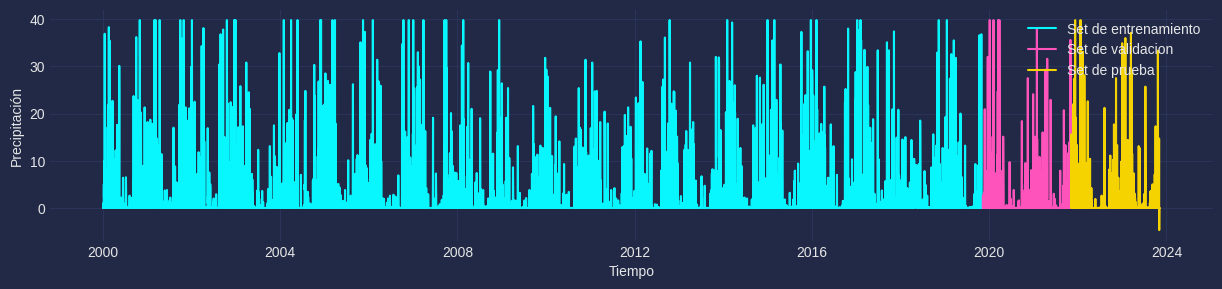

In [500]:
plt.figure(figsize=(15,3))
sns.lineplot(data=train, x="time", y="precipitation_sum", legend="brief", label="Set de entrenamiento");
sns.lineplot(data=valid, x="time", y="precipitation_sum", legend="brief", label="Set de validacion")
sns.lineplot(data=test, x="time", y="precipitation_sum", legend="brief", label="Set de prueba")
plt.xlabel("Tiempo")
plt.ylabel("Precipitación")
plt.legend(loc="upper right");

#Feature selection

In [501]:
fs_rg = SelectKBest(score_func=f_regression, k=40)
X_train = fs_rg.fit_transform(train.drop(["precipitation_sum"], axis=1), train["precipitation_sum"])
X_test = fs_rg.transform(test.drop(["precipitation_sum"], axis=1))
X_val = fs_rg.transform(valid.drop(["precipitation_sum"], axis=1))
train.shape, X_train.shape

((7251, 43), (7251, 40))

In [502]:
train = train[fs_rg.get_feature_names_out().tolist()+["precipitation_sum"]].copy()
test = test[fs_rg.get_feature_names_out().tolist()+["precipitation_sum"]].copy()
valid = valid[fs_rg.get_feature_names_out().tolist()+["precipitation_sum"]].copy()

## Caracteristicas mas importantes

<IPython.core.display.Javascript object>

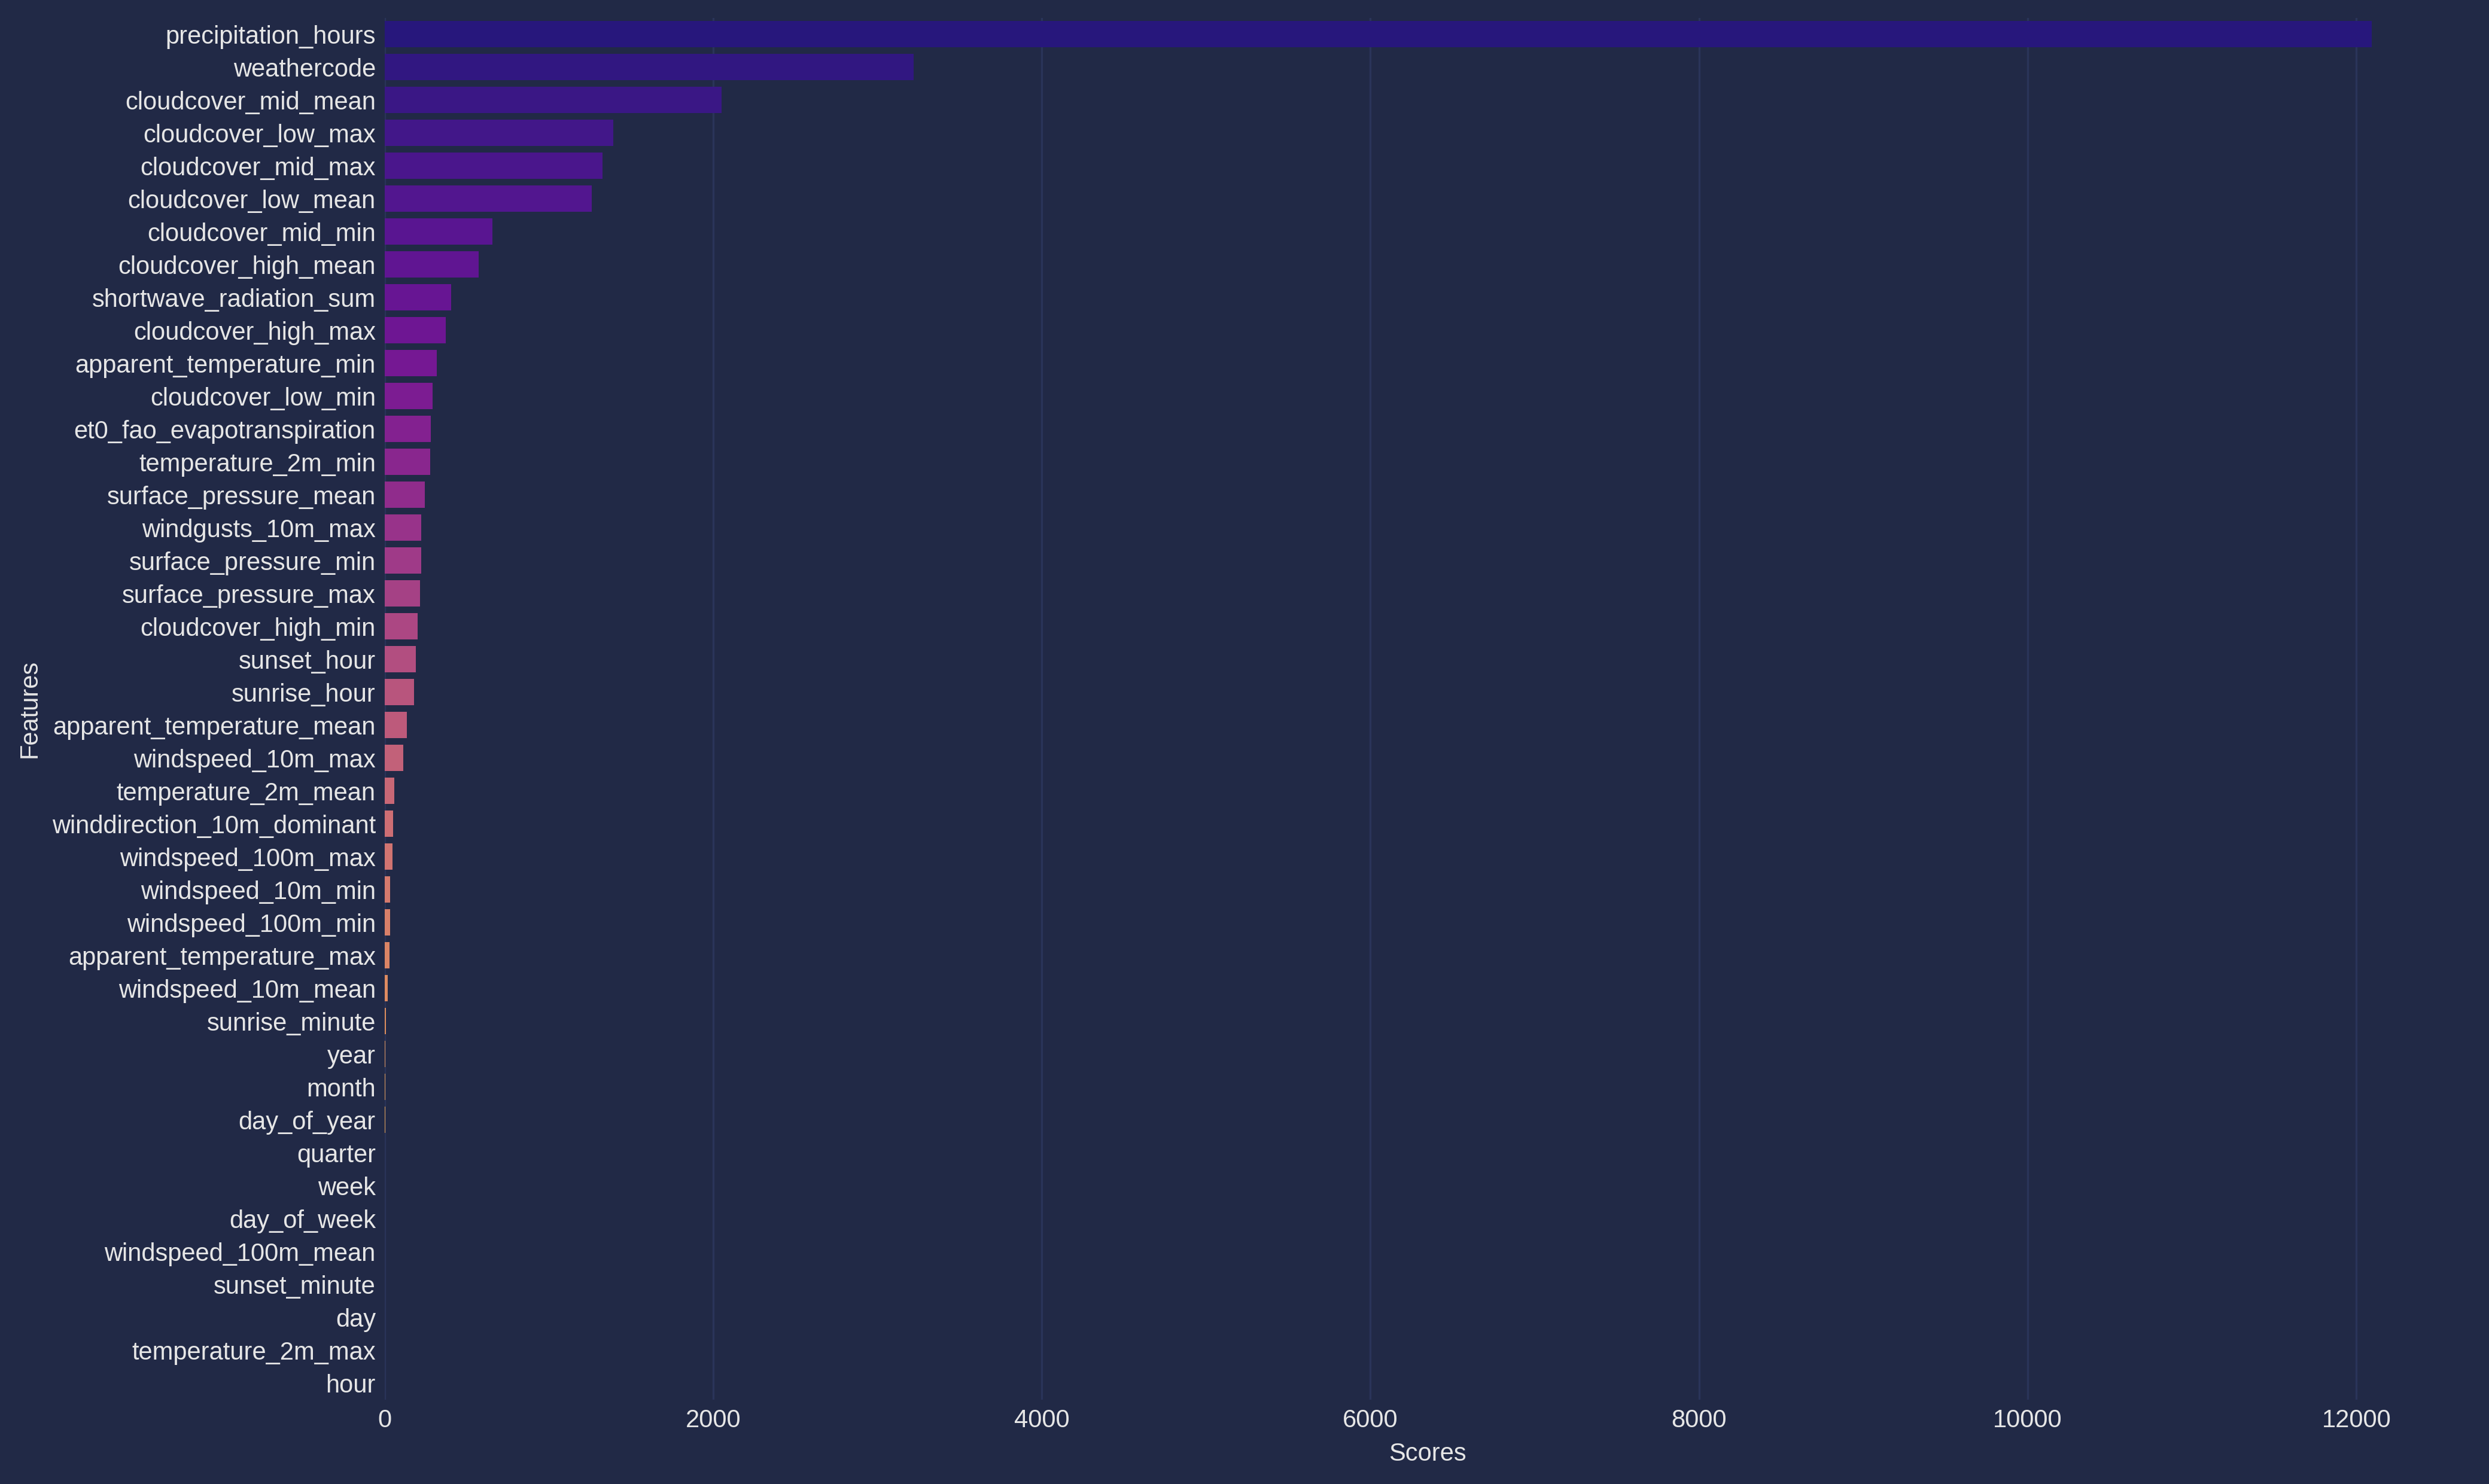

In [503]:
adjust_display()
plt.figure(figsize=(15, 10), dpi=300)
feature_scores = pd.DataFrame({"Features":fs_rg.feature_names_in_, "Scores":fs_rg.scores_})
sns.barplot(data=feature_scores, x="Scores", y="Features", palette="plasma", order=feature_scores.sort_values(by="Scores", ascending=False)["Features"]);

## Correlaciones

<IPython.core.display.Javascript object>

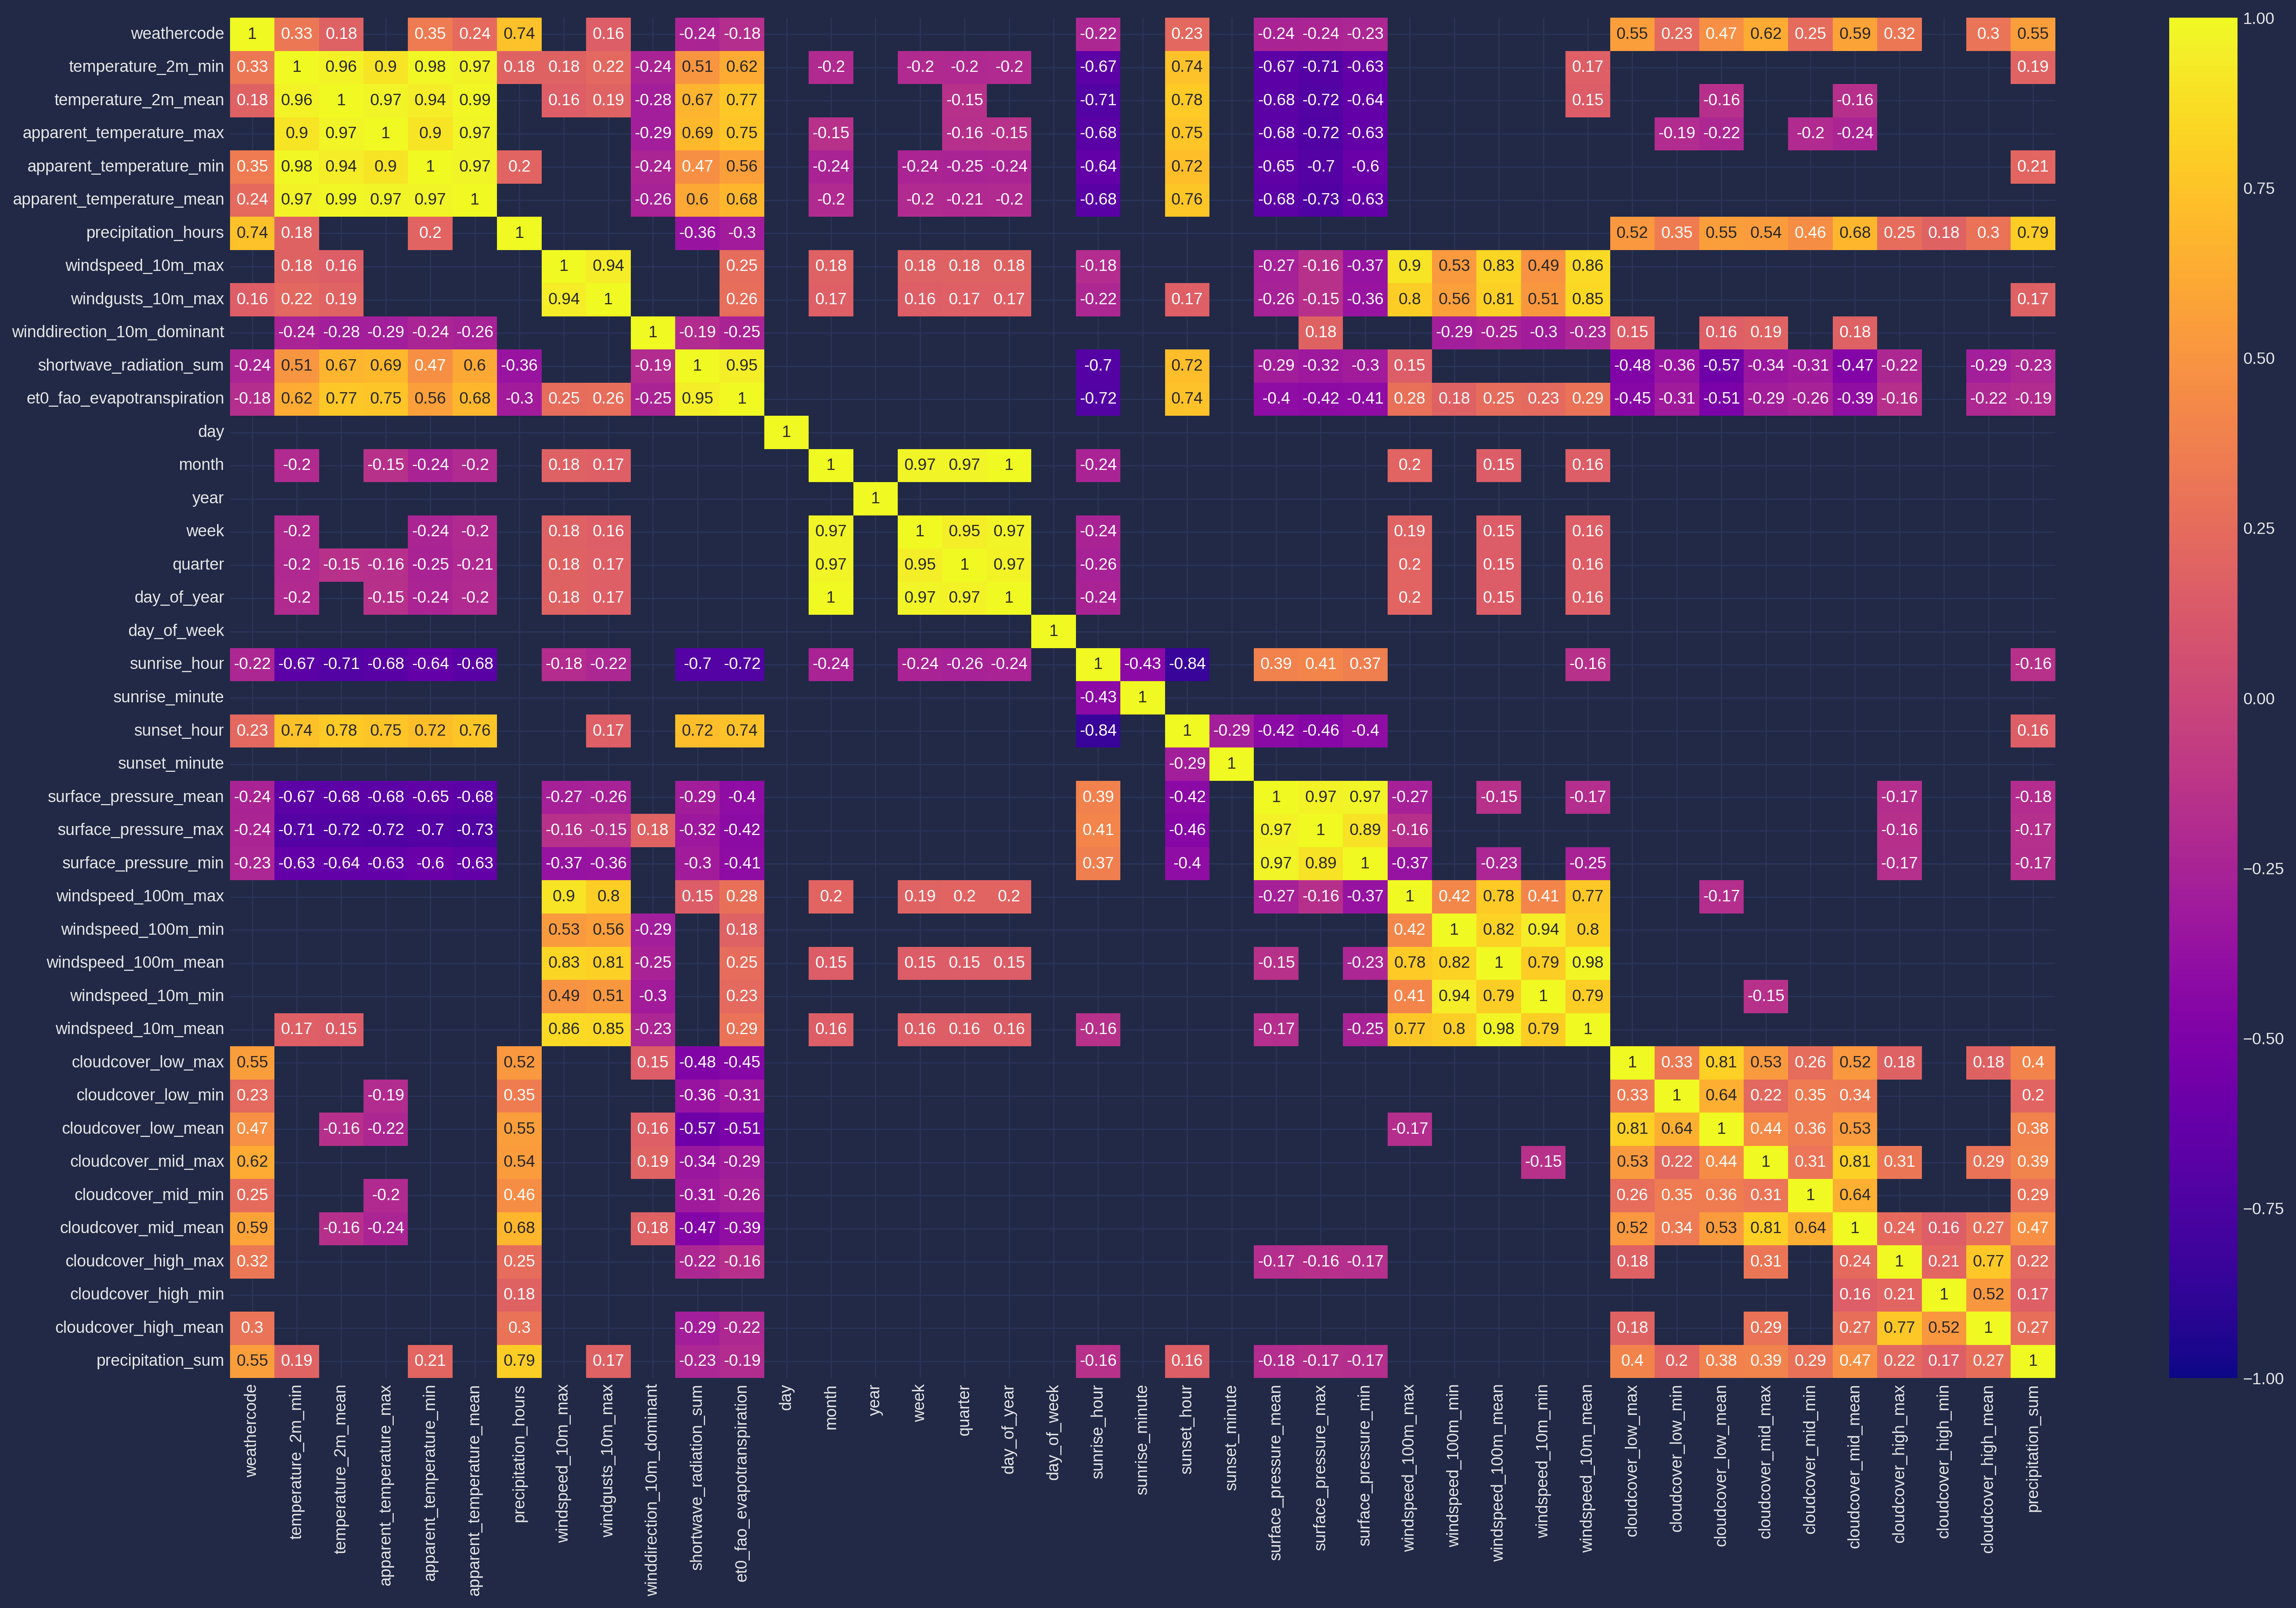

In [504]:
adjust_display()

plt.figure(figsize=(25, 15), dpi=300)
sns.heatmap(train.corr(), cmap="plasma", vmin=-1, vmax=1, mask=np.abs(train.corr()) < 0.15, annot=True);

In [505]:
def detect_VIF(train):
    train_ = train.copy()
    train_['intercept'] = 1
    with np.errstate(divide='ignore'):
        while(True):
            train_vif = pd.DataFrame(columns=["Features", "VIF"])
            train_vif["Features"] = train_.columns
            train_vif["VIF"] = [variance_inflation_factor(train_.values, i) for i in range(len(train_.columns))]
            train_vif = train_vif[train_vif["Features"] != "intercept"].sort_values("VIF", ascending=False)
            if train_vif.iloc[0]["VIF"] > 10:
                train_.drop([train_vif.iloc[0]["Features"]], axis=1, inplace=True)
            else:
                break
    train_.drop(["intercept"], axis=1, inplace=True)
    return train[train_.columns.tolist()].copy(), train_vif.reset_index(drop=True)

train_clean, train_vif = detect_VIF(train.drop(["precipitation_sum"], axis=1))
train_vif

Features       VIF
0         surface_pressure_max  8.022416
1         surface_pressure_min  7.523084
2          cloudcover_mid_mean  7.099017
3          cloudcover_low_mean  5.999880
4           temperature_2m_min  5.252418
5           cloudcover_mid_max  4.506666
6           cloudcover_low_max  4.318060
7            windgusts_10m_max  4.314703
8         cloudcover_high_mean  3.769271
9                  sunset_hour  3.580120
10          windspeed_100m_max  3.470705
11         precipitation_hours  3.309059
12                 weathercode  3.222284
13         cloudcover_high_max  2.908902
14          cloudcover_mid_min  2.296741
15          cloudcover_low_min  2.162518
16           windspeed_10m_min  1.779171
17         cloudcover_high_min  1.569747
18               sunset_minute  1.360659
19  winddirection_10m_dominant  1.274514
20                        week  1.215937
21              sunrise_minute  1.025122
22                        year  1.016428
23                         day  1.011640
24                 day_of_week  1.001484

In [506]:
train = pd.concat([train_clean, train["precipitation_sum"]], axis=1)

<IPython.core.display.Javascript object>

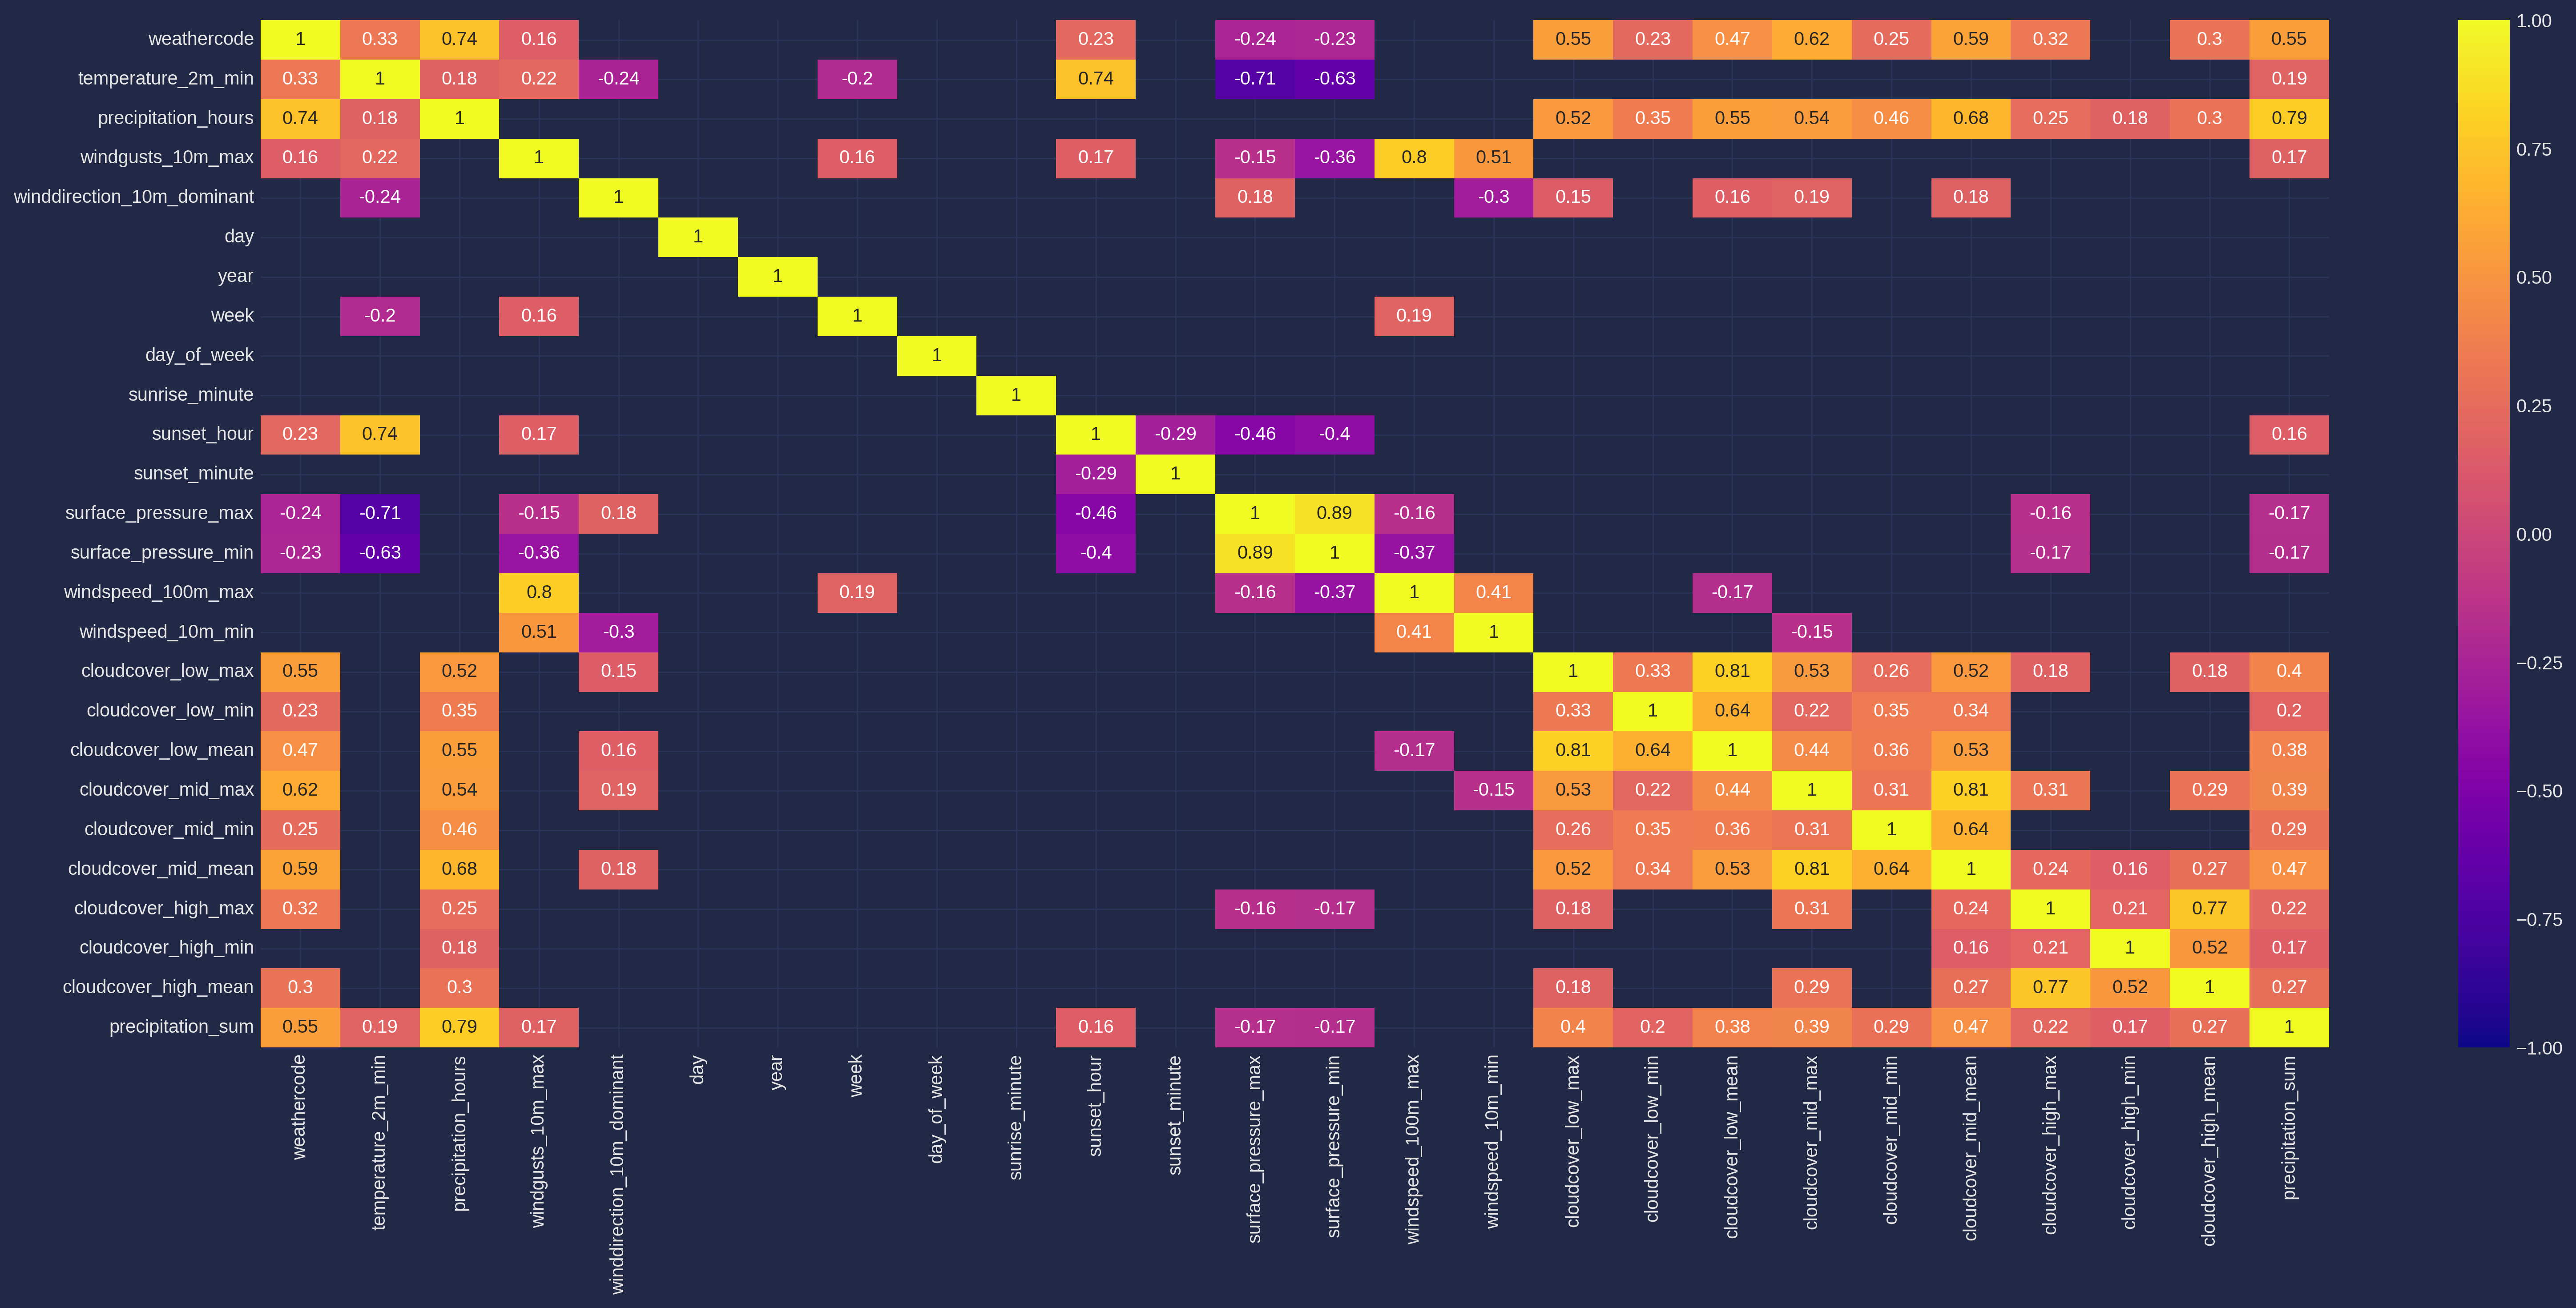

In [507]:
adjust_display()

plt.figure(figsize=(25, 10), dpi=300)
sns.heatmap(train.corr(), cmap="plasma", vmin=-1, vmax=1, mask=np.abs(train.corr()) < 0.15, annot=True);

In [508]:
df_train = train.copy()
df_test = test[train.columns].copy()
df_valid = valid[train.columns].copy()

# Feature Scaling

In [509]:
mms_X = MinMaxScaler()
mms_y = MinMaxScaler()

train_arr_X = mms_X.fit_transform(df_train.drop(["precipitation_sum"], axis=1)).astype("float32")
train_arr_y = mms_y.fit_transform(df_train[["precipitation_sum"]]).astype("float32")

valid_arr_X = mms_X.fit_transform(df_valid.drop(["precipitation_sum"], axis=1)).astype("float32")
valid_arr_y = mms_y.fit_transform(df_valid[["precipitation_sum"]]).astype("float32")

test_arr_X = mms_X.transform(df_test.drop(["precipitation_sum"], axis=1)).astype("float32")
test_arr_y = mms_y.transform(df_test[["precipitation_sum"]]).astype("float32")

train_arr = np.hstack([train_arr_X, train_arr_y])
valid_arr = np.hstack([valid_arr_X, valid_arr_y])
test_arr = np.hstack([test_arr_X, test_arr_y])

# Ventanas temporales

Nuestra ventana temporal observara el sondeo de un tiempo de largo "window_size" y avanzara "step_size" pasos por el dataset. Aqui hay una cuestion para realizar la prediccion para el primer dia del set de prueba, necesitamos los "window_size" dias previos a este. Por lo que los añadiremos previamente.

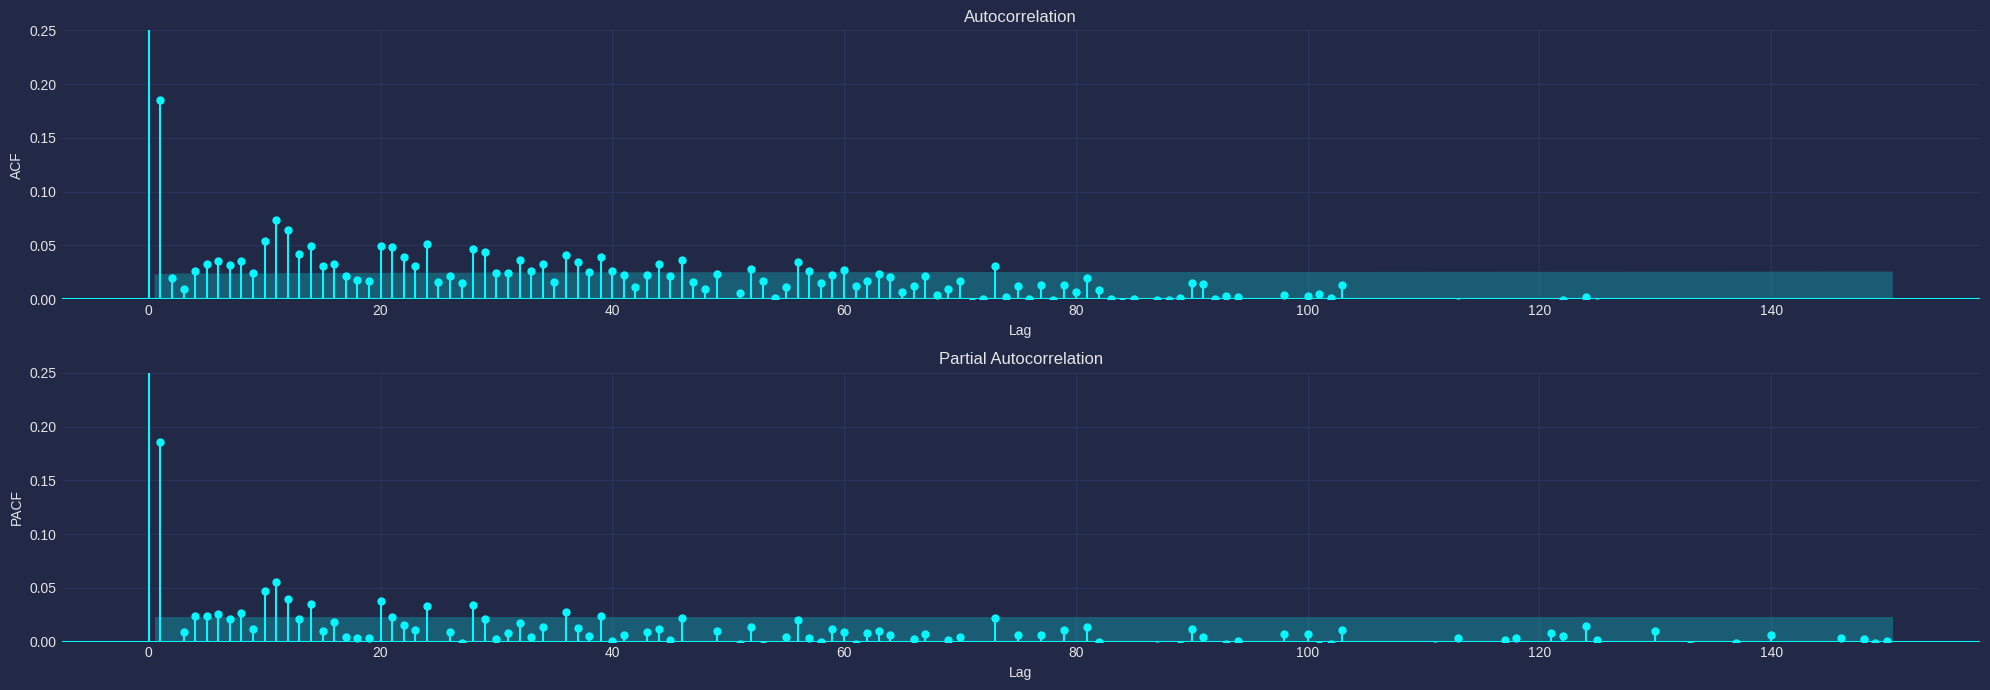

In [510]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs= plt.subplots(2, 1, figsize=(20, 7))
lags = 150

plt.subplot(2, 1, 1)
plot_acf(train_arr[:, -1], lags=lags, ax=axs[0])
plt.ylim(0, 0.25)
plt.xlabel("Lag")
plt.ylabel("ACF")

plt.subplot(2, 1, 2)
plot_pacf(train_arr[:, -1], lags=lags, ax=axs[1])
plt.ylim(0, 0.25)
plt.xlabel("Lag")
plt.ylabel("PACF");

plt.tight_layout()

In [511]:
from statsmodels.tsa.stattools import acf

df_lags = pd.DataFrame(data={"Lags":np.arange(0, lags+1), "ACF":acf(x=train_arr[:,-1], nlags=lags)}).sort_values("ACF", ascending=False)
df_lags.head(10)

Lags       ACF
0      0  1.000000
1      1  0.185543
11    11  0.073830
12    12  0.064190
10    10  0.053641
24    24  0.050861
20    20  0.049627
14    14  0.049002
21    21  0.048443
28    28  0.046626

Nos enfocaremos en los lags mayores a 0, ya que con lag-0 estamos ante la autocorrelacion de la señal consigo misma sin retrasar.

In [512]:
lags = df_lags[df_lags.Lags > 0 ]["Lags"].values[0]

In [513]:
def get_indices(data, window_size, step_size):
  last_step = len(data) # El -1 es debido a que la secuencia inicia en 0

  window_start = 0
  window_end = window_size

  indices = []

  while window_end <= last_step:
    indices.append((window_start, window_end))

    window_start += step_size
    window_end += step_size

  return indices

window_size = lags + 1 #Empieza con cero
target_size = 1
step_size = 1

train_indices = get_indices(train_arr, window_size+target_size, step_size)
valid_indices = get_indices(valid_arr, window_size+target_size, step_size)

print(train_indices)

[(0, 3), (1, 4), (2, 5), (3, 6), (4, 7), (5, 8), (6, 9), (7, 10), (8, 11), (9, 12), (10, 13), (11, 14), (12, 15), (13, 16), (14, 17), (15, 18), (16, 19), (17, 20), (18, 21), (19, 22), (20, 23), (21, 24), (22, 25), (23, 26), (24, 27), (25, 28), (26, 29), (27, 30), (28, 31), (29, 32), (30, 33), (31, 34), (32, 35), (33, 36), (34, 37), (35, 38), (36, 39), (37, 40), (38, 41), (39, 42), (40, 43), (41, 44), (42, 45), (43, 46), (44, 47), (45, 48), (46, 49), (47, 50), (48, 51), (49, 52), (50, 53), (51, 54), (52, 55), (53, 56), (54, 57), (55, 58), (56, 59), (57, 60), (58, 61), (59, 62), (60, 63), (61, 64), (62, 65), (63, 66), (64, 67), (65, 68), (66, 69), (67, 70), (68, 71), (69, 72), (70, 73), (71, 74), (72, 75), (73, 76), (74, 77), (75, 78), (76, 79), (77, 80), (78, 81), (79, 82), (80, 83), (81, 84), (82, 85), (83, 86), (84, 87), (85, 88), (86, 89), (87, 90), (88, 91), (89, 92), (90, 93), (91, 94), (92, 95), (93, 96), (94, 97), (95, 98), (96, 99), (97, 100), (98, 101), (99, 102), (100, 103), (

In [514]:
print(valid_indices)

[(0, 3), (1, 4), (2, 5), (3, 6), (4, 7), (5, 8), (6, 9), (7, 10), (8, 11), (9, 12), (10, 13), (11, 14), (12, 15), (13, 16), (14, 17), (15, 18), (16, 19), (17, 20), (18, 21), (19, 22), (20, 23), (21, 24), (22, 25), (23, 26), (24, 27), (25, 28), (26, 29), (27, 30), (28, 31), (29, 32), (30, 33), (31, 34), (32, 35), (33, 36), (34, 37), (35, 38), (36, 39), (37, 40), (38, 41), (39, 42), (40, 43), (41, 44), (42, 45), (43, 46), (44, 47), (45, 48), (46, 49), (47, 50), (48, 51), (49, 52), (50, 53), (51, 54), (52, 55), (53, 56), (54, 57), (55, 58), (56, 59), (57, 60), (58, 61), (59, 62), (60, 63), (61, 64), (62, 65), (63, 66), (64, 67), (65, 68), (66, 69), (67, 70), (68, 71), (69, 72), (70, 73), (71, 74), (72, 75), (73, 76), (74, 77), (75, 78), (76, 79), (77, 80), (78, 81), (79, 82), (80, 83), (81, 84), (82, 85), (83, 86), (84, 87), (85, 88), (86, 89), (87, 90), (88, 91), (89, 92), (90, 93), (91, 94), (92, 95), (93, 96), (94, 97), (95, 98), (96, 99), (97, 100), (98, 101), (99, 102), (100, 103), (

In [515]:
test_arr_ = np.vstack([valid_arr[-window_size:], test_arr])
test_indices = get_indices(test_arr_, window_size+target_size, step_size)
print(test_indices)

[(0, 3), (1, 4), (2, 5), (3, 6), (4, 7), (5, 8), (6, 9), (7, 10), (8, 11), (9, 12), (10, 13), (11, 14), (12, 15), (13, 16), (14, 17), (15, 18), (16, 19), (17, 20), (18, 21), (19, 22), (20, 23), (21, 24), (22, 25), (23, 26), (24, 27), (25, 28), (26, 29), (27, 30), (28, 31), (29, 32), (30, 33), (31, 34), (32, 35), (33, 36), (34, 37), (35, 38), (36, 39), (37, 40), (38, 41), (39, 42), (40, 43), (41, 44), (42, 45), (43, 46), (44, 47), (45, 48), (46, 49), (47, 50), (48, 51), (49, 52), (50, 53), (51, 54), (52, 55), (53, 56), (54, 57), (55, 58), (56, 59), (57, 60), (58, 61), (59, 62), (60, 63), (61, 64), (62, 65), (63, 66), (64, 67), (65, 68), (66, 69), (67, 70), (68, 71), (69, 72), (70, 73), (71, 74), (72, 75), (73, 76), (74, 77), (75, 78), (76, 79), (77, 80), (78, 81), (79, 82), (80, 83), (81, 84), (82, 85), (83, 86), (84, 87), (85, 88), (86, 89), (87, 90), (88, 91), (89, 92), (90, 93), (91, 94), (92, 95), (93, 96), (94, 97), (95, 98), (96, 99), (97, 100), (98, 101), (99, 102), (100, 103), (

Como podemos ver los sets de datos, tanto de entramiento como de prueba, seran transformados en subset de largo "window_size + target_size" y la posicion temporal de cada ventana estara desplazada "step_size" pasos de la anterior, lo que se busca lograr es que una ventana de "window_size" logre predecir una ventana de "target_size".

<img src="https://drive.google.com/uc?export=view&id=1MsQm7Dhpi8ZIMScsWJ5Z4Wc3lM82FJvO" height=300>

Ahora bien, sabemos que dentro de una ventana de tamaño "window_size + target_size" tendremos:
+ Una matriz de datos de contexto de tamaño "window_size".
+ Un array de tamaño "target_size" del target a predecir.

En sintesis, cada ventana nos dara como resultado una prediccion, asi cada ventana representa un dato en forma de matriz y una prediccion en forma de array, para que el modelo pueda entrenar de estos datos debemos transformar la matriz en un array.

In [516]:
def get_X_y(data, indices, target_window, input_window):
  y = np.array([], dtype="float32").reshape(0, target_window)
  X = np.array([], dtype="float32").reshape(0, window_size*data.shape[1])

  for idx in indices:
    sample = data[idx[0]:idx[1]]
    sample_input = sample[0:input_window]

    assert input_window == len(sample_input)

    sample_target = sample[input_window:input_window+target_window][:, -1]

    y = np.vstack([y, sample_target.reshape(1, -1)])
    X = np.vstack([X, sample_input.reshape(1, -1)])

  return X, y

X_train, y_train = get_X_y(train_arr, train_indices, target_size, window_size)
X_valid, y_valid = get_X_y(valid_arr, valid_indices, target_size, window_size)
X_test, y_test = get_X_y(test_arr_, test_indices, target_size, window_size)

De esta forma veremos que tenemos la siguiente cantidad de ventanas

In [517]:
len(train_indices)

7249

Y por lo tanto tendremos la misma cantidad de registros y predicciones como ventanas dispongamos

In [518]:
X_train.shape, y_train.shape

((7249, 52), (7249, 1))

# Prediciendo precipitationes

## Estructurando los datos para mejorar eficiencia y velocidad de entrenamiento con DMatrix

In [519]:
train_data = DMatrix(X_train, label=y_train)
valid_data = DMatrix(X_valid, label=y_valid)
test_data = DMatrix(X_test, label=y_test)

## Entrenamiento del modelo

In [520]:
evals_result = {
    'train': {'mae': []},
    'eval': {'mae': []}
    }

params = {
    #"device":"cuda",
    "objective":"reg:squarederror",
    "eval_metric":"mae",
    "random_state":42,
    "learning_rate":0.005,
    "lambda":500,
    "gamma":0.001,
    "max_depth":6,
    "tree_method":"hist",
    "num_parallel_tree":50,
    "min_child_weight":6,
}

rounds = 20

model = xgbtrain(
    params=params,
    dtrain=train_data,
    num_boost_round=4000,
    verbose_eval=5,
    evals=[(train_data, 'train'), (valid_data, 'valid')],
    evals_result=evals_result,
    early_stopping_rounds=rounds
)
#0.06564 #Aumentar el tamaño de la ventana mejora sustancialmente las predicciones, modificar lambda tambien.

[0]	train-mae:0.07757	valid-mae:0.07384
[5]	train-mae:0.07720	valid-mae:0.07343
[10]	train-mae:0.07685	valid-mae:0.07303
[15]	train-mae:0.07650	valid-mae:0.07264
[20]	train-mae:0.07617	valid-mae:0.07226
[25]	train-mae:0.07584	valid-mae:0.07189
[30]	train-mae:0.07552	valid-mae:0.07153
[35]	train-mae:0.07521	valid-mae:0.07117
[40]	train-mae:0.07491	valid-mae:0.07084
[45]	train-mae:0.07462	valid-mae:0.07050
[50]	train-mae:0.07433	valid-mae:0.07019
[55]	train-mae:0.07405	valid-mae:0.06987
[60]	train-mae:0.07378	valid-mae:0.06957
[65]	train-mae:0.07351	valid-mae:0.06927
[70]	train-mae:0.07325	valid-mae:0.06898
[75]	train-mae:0.07299	valid-mae:0.06868
[80]	train-mae:0.07274	valid-mae:0.06839
[85]	train-mae:0.07250	valid-mae:0.06810
[90]	train-mae:0.07225	valid-mae:0.06781
[95]	train-mae:0.07201	valid-mae:0.06753
[100]	train-mae:0.07177	valid-mae:0.06726
[105]	train-mae:0.07154	valid-mae:0.06699
[110]	train-mae:0.07132	valid-mae:0.06673
[115]	train-mae:0.07110	valid-mae:0.06648
[120]	train-ma

In [521]:
model.best_score

0.0524932413099295

## Visualizando las perdidas durante el entrenamiento

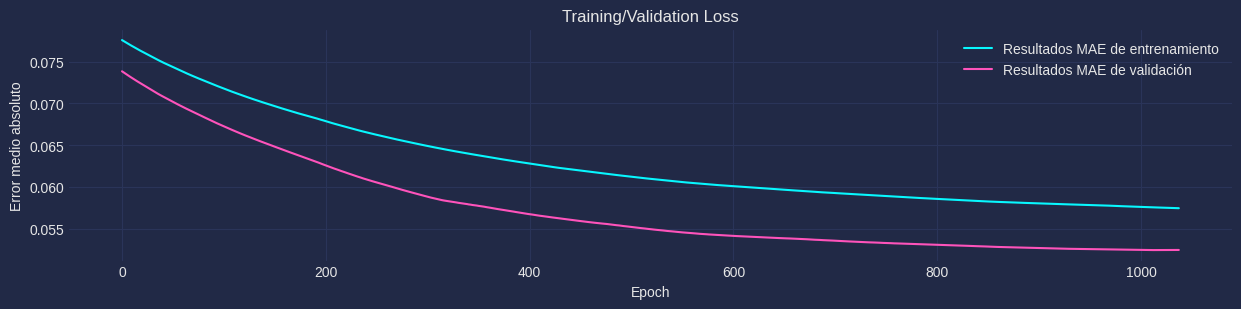

In [522]:
x = np.arange(0, len(evals_result["train"]["mae"]))

plt.figure(figsize=(15, 3))
sns.lineplot(x=x, y=evals_result["train"]["mae"], legend="brief", label="Resultados MAE de entrenamiento")
sns.lineplot(x=x, y=evals_result["valid"]["mae"], legend="brief", label="Resultados MAE de validación")
plt.xlabel("Epoch")
plt.ylabel("Error medio absoluto")
plt.title("Training/Validation Loss");

## Visualizando predicciones

In [523]:
y_test_predict = model.predict(test_data)
y_test_predict = mms_y.inverse_transform([y_test_predict.flatten()])[0]

In [524]:
mms_y.inverse_transform([y_test.flatten()])[0].shape, test_arr_X.shape

((730,), (730, 25))

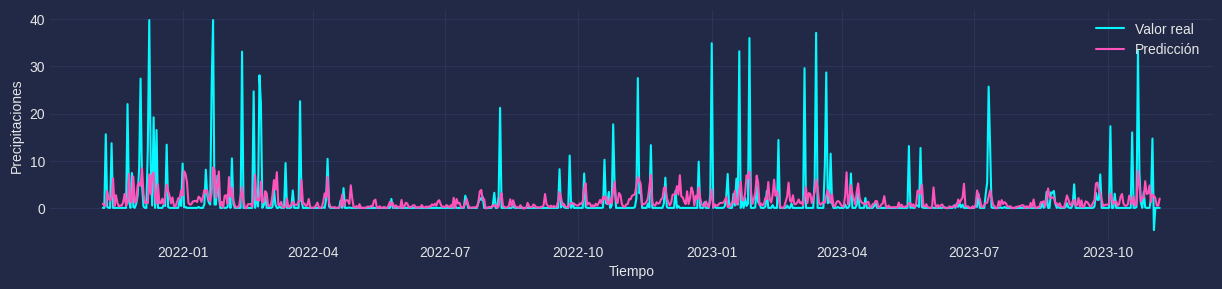

In [525]:
dates = pd.to_datetime(df_test.index)
plt.figure(figsize=(15, 3))
sns.lineplot(x=dates, y=mms_y.inverse_transform([y_test.flatten()])[0], legend="brief", label="Valor real")
sns.lineplot(x=dates, y=y_test_predict, legend="brief", label="Predicción")
plt.xlabel("Tiempo")
plt.ylabel("Precipitaciones")
plt.legend(loc="upper right");

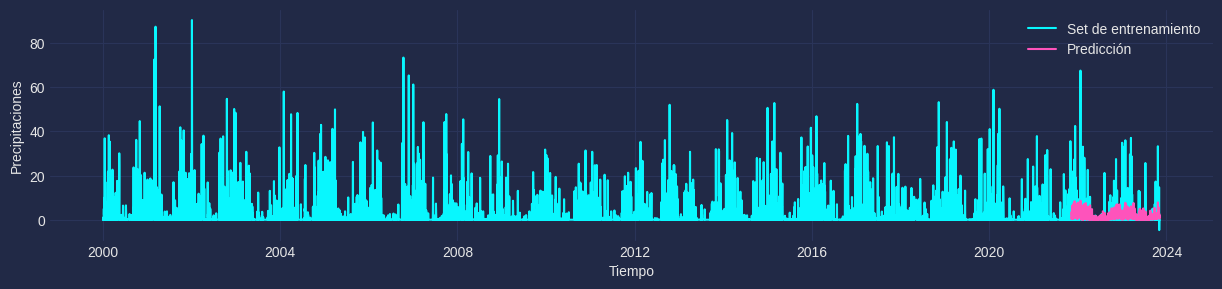

In [526]:
plt.figure(figsize=(15, 3))
sns.lineplot(x=df.index, y=df["precipitation_sum"], legend="brief", label="Set de entrenamiento")
sns.lineplot(x=dates, y=y_test_predict, legend="brief", label="Predicción");
plt.xlabel("Tiempo")
plt.ylabel("Precipitaciones");